# Binning Time Series


## Re-Engineering Raw Crime Data
Previously, we created a crime counts dataset from the Baltimore Crime Data that allowed us to create a high-level summary of how many of which types of crimes occur on a given day.
This was great for basic time series visualization, but we lost most of the nuance/detail that we originally had.
Let's revisit the original crime data and perform some feature engineering for EDA purposes.

In [61]:
#!pip install holidays


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.2/378.2 kB 948.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 1.1 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 4.4 MB/s eta 0:00:00
  Created wheel for PyMeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=ebdb3888e729cc3b9efdcb690db816bbfdab5e2581cb3fafa55bbefa75b8e802
  Stored in directory: /Users/danielbarella/Library/Caches/pip/wheels/9b/0a/31/eb0e590d74ec13e90493cb6d1cd92a379a1a3b8f12ed778a14
Successfully built PyMeeus


In [62]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import holidays
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)

In [2]:
pd.set_option('display.max_columns',100)

In [3]:
df = pd.read_csv('/Users/danielbarella/Downloads/Part_1_Crime_Data.csv',
                 low_memory=False, parse_dates=['CrimeDateTime'])
## Converting crimedatetime and coercing errors
df['CrimeDateTime'] = pd.to_datetime(df['CrimeDateTime'],errors='coerce')
df = df.dropna(subset=['CrimeDateTime'])
## setting and sorting the index
df = df.set_index("CrimeDateTime")
df = df.sort_index()
df.head(3)

,RowID,CCNO,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,Gender,Age,Race,Ethnicity,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,Total_Incidents
CrimeDateTime,,,,,,,,,,,,,,,,,,,
1920-06-18 01:30:00+00:00,556023,22F05949,3AO,3700 LEVERTON AVE,ROBBERY,Inside,PERSONAL_WEAPONS,223,M,20.0,WHITE,HISPANIC_OR_LATINO,SOUTHEAST,Baltimore Highlands,0.000000,0.000000,"(0,0)",STREET,1
1922-06-22 13:00:00+00:00,556005,22F07001,4E,1100 LIGHT ST,COMMON ASSAULT,Inside,PERSONAL_WEAPONS,942,M,58.0,WHITE,NaN,SOUTHERN,Federal Hill,39.276740,-76.612378,"(39.276739999999997,-76.612378000000007)",STREET,1
1963-10-30 00:00:00+00:00,556004,17K02992,2A,3100 FERNDALE AVE,RAPE,I,OTHER,622,F,32.0,BLACK_OR_AFRICAN_AMERICAN,NaN,NORTHWEST,HOWARD PARK,39.327591,-76.703216,"(39.3275908337086,-76.7032163534707)",ROW/TOWNHOUSE-OCC,1


In [4]:
## baltimore is in eastern time zone,but can just use tz-naive index by choosing None
df = df.tz_convert(None)
df.head(3)

,RowID,CCNO,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,Gender,Age,Race,Ethnicity,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,Total_Incidents
CrimeDateTime,,,,,,,,,,,,,,,,,,,
1920-06-18 01:30:00,556023,22F05949,3AO,3700 LEVERTON AVE,ROBBERY,Inside,PERSONAL_WEAPONS,223,M,20.0,WHITE,HISPANIC_OR_LATINO,SOUTHEAST,Baltimore Highlands,0.000000,0.000000,"(0,0)",STREET,1
1922-06-22 13:00:00,556005,22F07001,4E,1100 LIGHT ST,COMMON ASSAULT,Inside,PERSONAL_WEAPONS,942,M,58.0,WHITE,NaN,SOUTHERN,Federal Hill,39.276740,-76.612378,"(39.276739999999997,-76.612378000000007)",STREET,1
1963-10-30 00:00:00,556004,17K02992,2A,3100 FERNDALE AVE,RAPE,I,OTHER,622,F,32.0,BLACK_OR_AFRICAN_AMERICAN,NaN,NORTHWEST,HOWARD PARK,39.327591,-76.703216,"(39.3275908337086,-76.7032163534707)",ROW/TOWNHOUSE-OCC,1


Now, we will drop the columns that we will not need for our analysis:



In [5]:
## Drop extra columns not needed
drop_cols = ['CCNO','RowID','Post','GeoLocation',
            'Location','Premise']
df = df.drop(columns=drop_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 558343 entries, 1920-06-18 01:30:00 to 2023-03-25 23:20:00
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CrimeCode        558343 non-null  object 
 1   Description      558343 non-null  object 
 2   Inside_Outside   468412 non-null  object 
 3   Weapon           124658 non-null  object 
 4   Gender           468088 non-null  object 
 5   Age              445937 non-null  float64
 6   Race             547171 non-null  object 
 7   Ethnicity        21183 non-null   object 
 8   District         544332 non-null  object 
 9   Neighborhood     544200 non-null  object 
 10  Latitude         557432 non-null  float64
 11  Longitude        557432 non-null  float64
 12  Total_Incidents  558343 non-null  int64  
dtypes: float64(3), int64(1), object(9)
memory usage: 59.6+ MB


## Feature Engineering & Initial EDA
### Datetime components
Remember that date time objects in Python (and datetime indices in Pandas) contain methods and attributes for extracting specific pieces/components of the time series.
Let's save many individual pieces of our datetime column as separate features for EDA.
Let's separate out the date (without time) as its own column:

In [6]:
## saving just the date (no time) as a column
df['Date'] = df.index.date
# could also use .strftime + pd.to_datetime
# df['Date'] = pd.to_datetime(df.index.strftime('%Y-%m-%d'))
df.head(3)

,CrimeCode,Description,Inside_Outside,Weapon,Gender,Age,Race,Ethnicity,District,Neighborhood,Latitude,Longitude,Total_Incidents,Date
CrimeDateTime,,,,,,,,,,,,,,
1920-06-18 01:30:00,3AO,ROBBERY,Inside,PERSONAL_WEAPONS,M,20.0,WHITE,HISPANIC_OR_LATINO,SOUTHEAST,Baltimore Highlands,0.000000,0.000000,1,1920-06-18
1922-06-22 13:00:00,4E,COMMON ASSAULT,Inside,PERSONAL_WEAPONS,M,58.0,WHITE,NaN,SOUTHERN,Federal Hill,39.276740,-76.612378,1,1922-06-22
1963-10-30 00:00:00,2A,RAPE,I,OTHER,F,32.0,BLACK_OR_AFRICAN_AMERICAN,NaN,NORTHWEST,HOWARD PARK,39.327591,-76.703216,1,1963-10-30


## Year
Now let's create a column with just the year.

In [7]:
## Engineering Features using components of the date/time
df['Year']  = df.index.year

The most efficient way to explore the data is with a visual, so let's see how many crimes were documented each year with Seaborn's countplot.

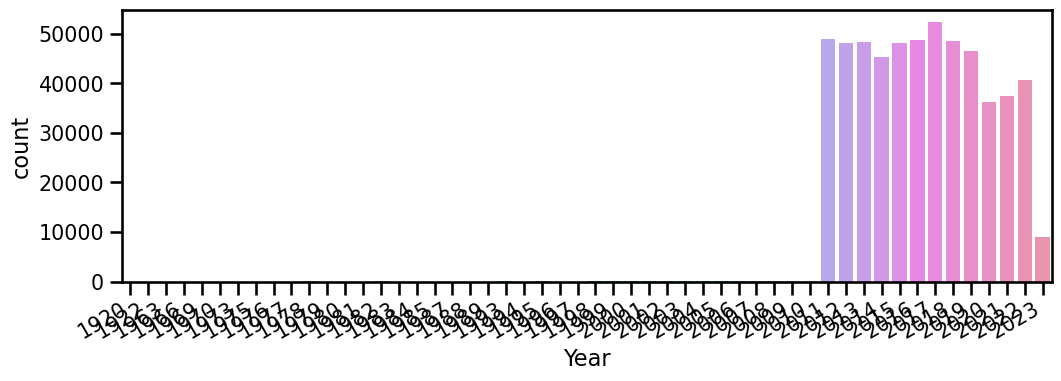

In [8]:
## Visualize years
ax = sns.countplot(data=df, x='Year')
fig = ax.get_figure()
fig.autofmt_xdate()

Wow! There are crimes documented from way back in the 1920s, but it looks like the consistent documentation in this dataset didn't start until more recently. We can check out the value counts to confirm:

In [9]:
df['Year'].value_counts().sort_index(ascending = False).head(15)


2023     8972
2022    40639
2021    37379
2020    36284
2019    46604
2018    48599
2017    52297
2016    48673
2015    48072
2014    45228
2013    48330
2012    48142
2011    48965
2010       27
2009       15
Name: Year, dtype: int64

Based on our dataset, let's only keep data from 2011 until the present:



In [10]:
## keeping data from yr 2011 to present
df = df.loc['2011':].copy()

Let's make another visual with only the more recent years included:



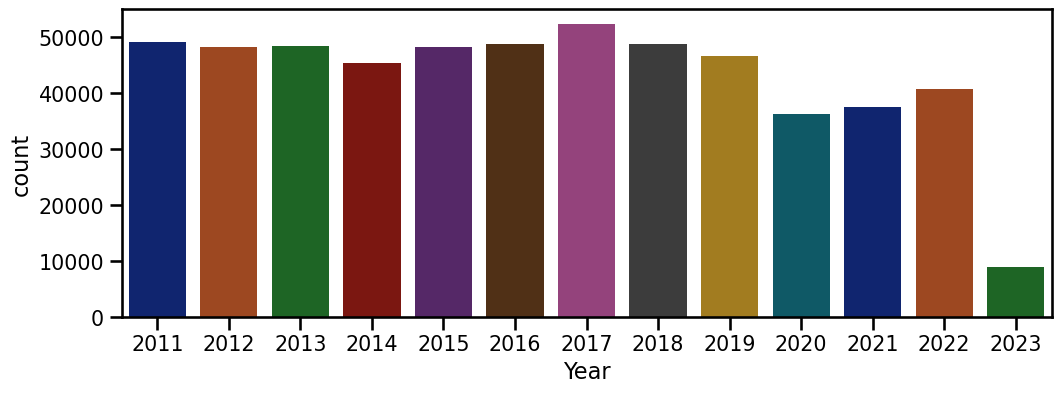

In [11]:
## visualizing again with years removed
sns.countplot(data=df, x='Year',palette='dark');

This gives us a much better representation of crimes by year. Let's save the year count data:



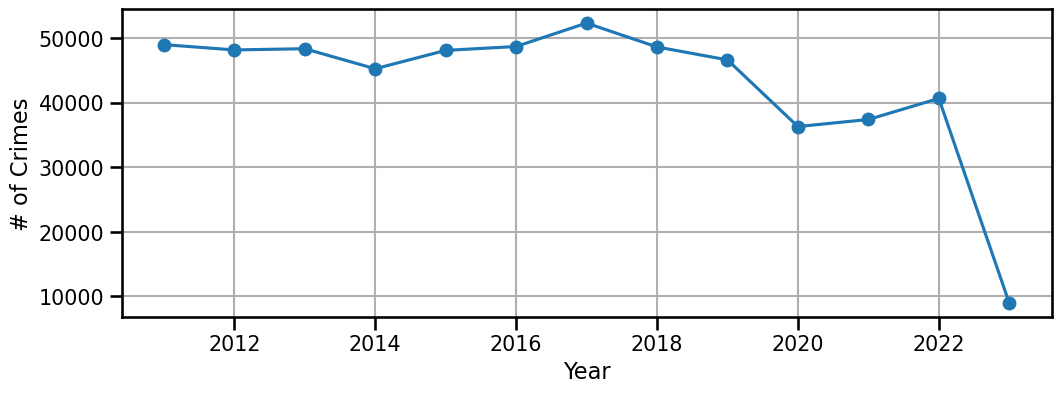

In [12]:
## save year counts
year_counts = df['Year'].value_counts().sort_index()
year_counts.plot(style='o-',grid=True,ylabel='# of Crimes', xlabel='Year');

As we can see above, it looks like overall total crime has decreased since the pandemic start in late 2019. (Keep in mind data was not completed for 2022 at the time this was produced)
## Month
Next, we want to see which months have higher or lower crime. As we did with year, we can pull out just the month from our Datetime and create a new column. We will also create a column with the name of the month. Having both will allow us to sort by the number to keep our months in order, and to display the name in our visuals.

In [13]:
## Extracting the Month
df['Month'] = df.index.month
df['MonthName'] = df.index.month_name()
df.head(3)

,CrimeCode,Description,Inside_Outside,Weapon,Gender,Age,Race,Ethnicity,District,Neighborhood,Latitude,Longitude,Total_Incidents,Date,Year,Month,MonthName
CrimeDateTime,,,,,,,,,,,,,,,,,
2011-01-01,2A,RAPE,NaN,OTHER,M,16.0,BLACK_OR_AFRICAN_AMERICAN,NaN,WESTERN,HARLEM PARK,39.298868,-76.639339,1,2011-01-01,2011,1,January
2011-01-01,6G,LARCENY,I,NaN,F,26.0,WHITE,NaN,SOUTHERN,FEDERAL HILL,39.277032,-76.613387,1,2011-01-01,2011,1,January
2011-01-01,6E,LARCENY,O,NaN,M,44.0,BLACK_OR_AFRICAN_AMERICAN,NaN,WESTERN,MOSHER,39.295730,-76.661589,1,2011-01-01,2011,1,January


We will now create a dictionary to match the number of the month with the name. This will allow us to keep our months in order by number:

In [14]:
# saving lookup for number vs name
unique_months = df.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup =dict(zip(unique_months['Month'],unique_months['MonthName']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

Now, let's make a countplot by month:



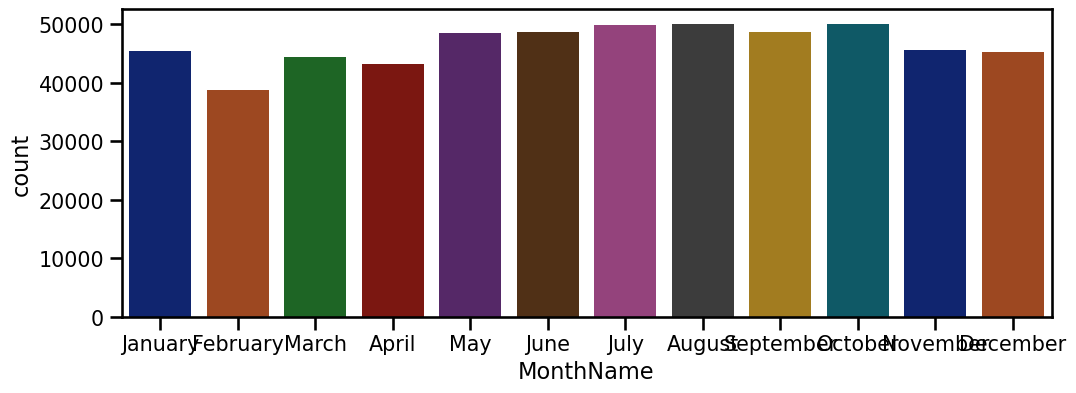

In [15]:
sns.countplot(data=df, x='MonthName',palette='dark',order=month_lookup.values());


Now, let's save our crime count by months:



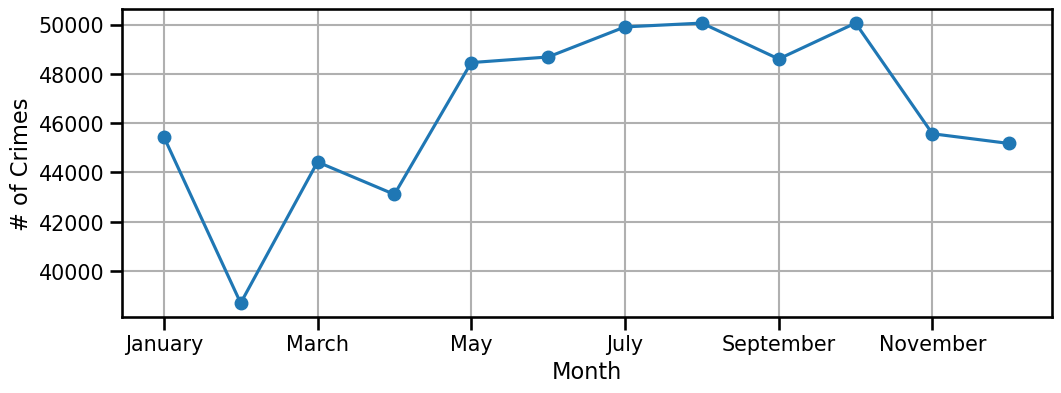

In [16]:
## save month counts
month_counts = df['MonthName'].value_counts()[month_lookup.values()]
# year_counts = df.groupby("Year").size()
ax = month_counts.plot(style='o-',grid=True,
                       ylabel='# of Crimes',
                       xlabel='Month');

As we can see above, it looks like the coldest months of the year have the fewest overall # of crimes.
## Day of Week
We can break down the crimes by day of the week in much the same way as we did with months. Again, we will create a column for both number of the day and name of the day:

In [17]:
## adding day of week as both number & name
df['DayOfWeek'] = df.index.day_name()
df['DayNum'] = df.index.day_of_week
df.head(3)

,CrimeCode,Description,Inside_Outside,Weapon,Gender,Age,Race,Ethnicity,District,Neighborhood,Latitude,Longitude,Total_Incidents,Date,Year,Month,MonthName,DayOfWeek,DayNum
CrimeDateTime,,,,,,,,,,,,,,,,,,,
2011-01-01,2A,RAPE,NaN,OTHER,M,16.0,BLACK_OR_AFRICAN_AMERICAN,NaN,WESTERN,HARLEM PARK,39.298868,-76.639339,1,2011-01-01,2011,1,January,Saturday,5
2011-01-01,6G,LARCENY,I,NaN,F,26.0,WHITE,NaN,SOUTHERN,FEDERAL HILL,39.277032,-76.613387,1,2011-01-01,2011,1,January,Saturday,5
2011-01-01,6E,LARCENY,O,NaN,M,44.0,BLACK_OR_AFRICAN_AMERICAN,NaN,WESTERN,MOSHER,39.295730,-76.661589,1,2011-01-01,2011,1,January,Saturday,5


Again, we will create a dictionary to match the number and the name:


In [18]:
# saving lookup for number vs named days
unique_days = df.drop_duplicates(subset=['DayNum']).sort_values('DayNum')
day_lookup =dict(zip(unique_days['DayNum'],unique_days['DayOfWeek']))
day_lookup

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

When datetime's day_of_week, the numbering starts on Monday, where Monday=0.


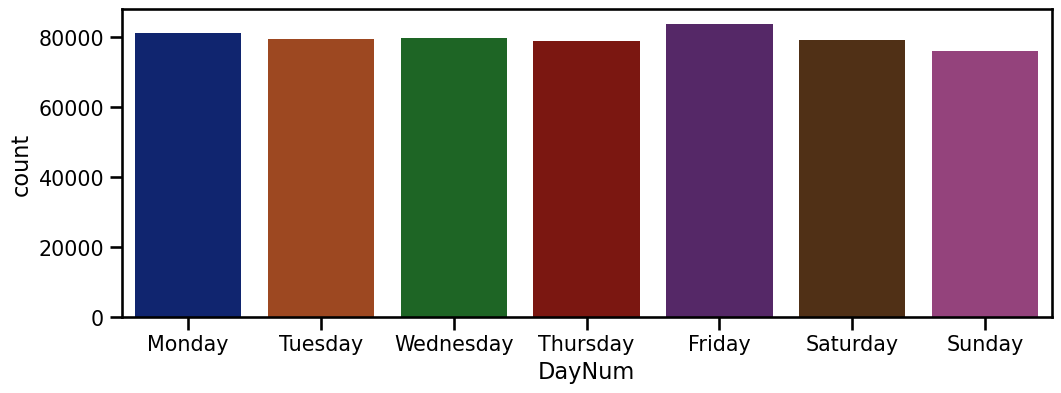

In [19]:
## plot DayNum, but use names from day_lookup for ticks
ax = sns.countplot(data=df, x='DayNum',palette='dark')
ax.set_xticklabels([v for k,v in day_lookup.items()]);

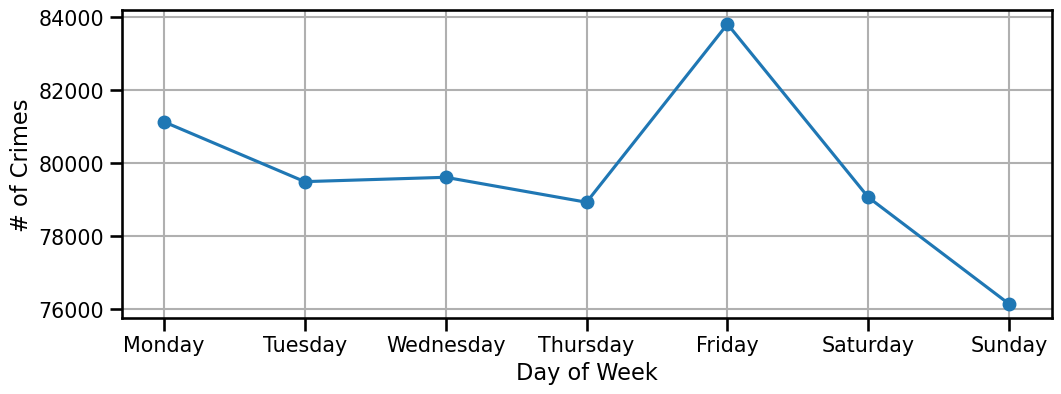

In [20]:
## save day counts
day_counts = df['DayNum'].value_counts().sort_index()
## now that its in order, rename using day_lookup
day_counts = day_counts.rename(day_lookup)
ax = day_counts.plot(style='o-',grid=True,ylabel='# of Crimes', xlabel='Day of Week')

It looks like crime is highest on Fridays and lowest on Sundays.
## Weekend
Next, let's see how crime on weekend days compares with crime on weekdays:


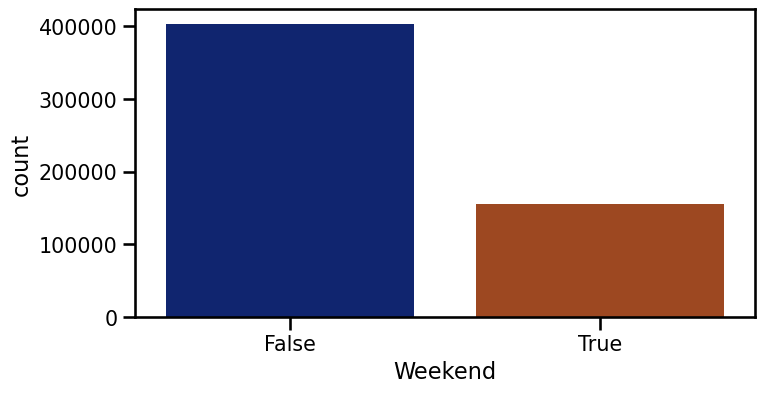

In [21]:
df['Weekend'] = df['DayOfWeek'].isin(['Saturday','Sunday'])
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Weekend',palette='dark');

At first glance, this graph could be misleading. It looks like crime is much more common on weekdays, BUT remember there are 5 weekdays and only 2 weekend days. A better approach is to normalize this for comparison by looking at crimes per day.

In [22]:
## calculating value counts and then dividing week days by 5 and weekend by 2
weekend_counts = df["Weekend"].value_counts()
weekend_counts.loc[False] /= 5
weekend_counts.loc[True] /= 2
weekend_counts

False    80596.6
True     77600.5
Name: Weekend, dtype: float64

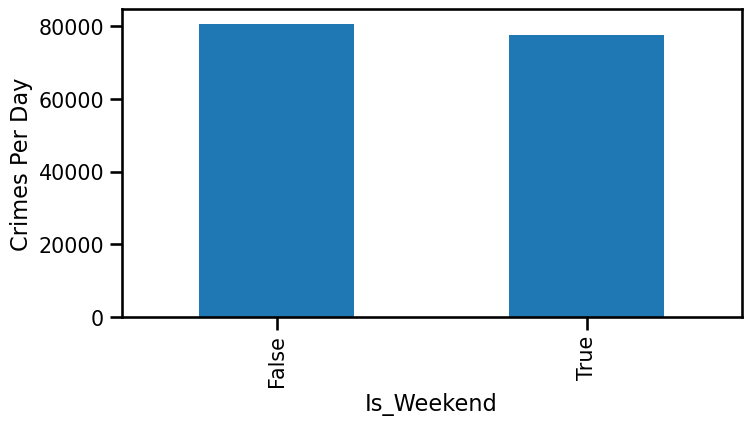

In [23]:
ax = weekend_counts.plot(kind='bar',figsize=(8,4))
ax.set(ylabel='Crimes Per Day', xlabel='Is_Weekend');

After normalizing by # of days, weekends and weekdays look much closer.

## Hour of the Day
We can also compare each hour of the day to see when crimes are the most likely:

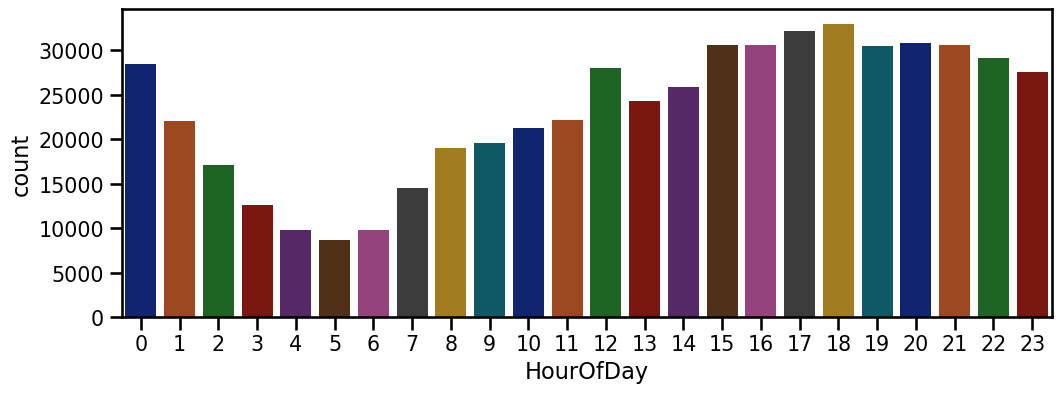

In [24]:
# adding hour of the day (12am=0) 
df['HourOfDay'] = df.index.hour 
sns.countplot(data=df, x='HourOfDay',palette='dark');

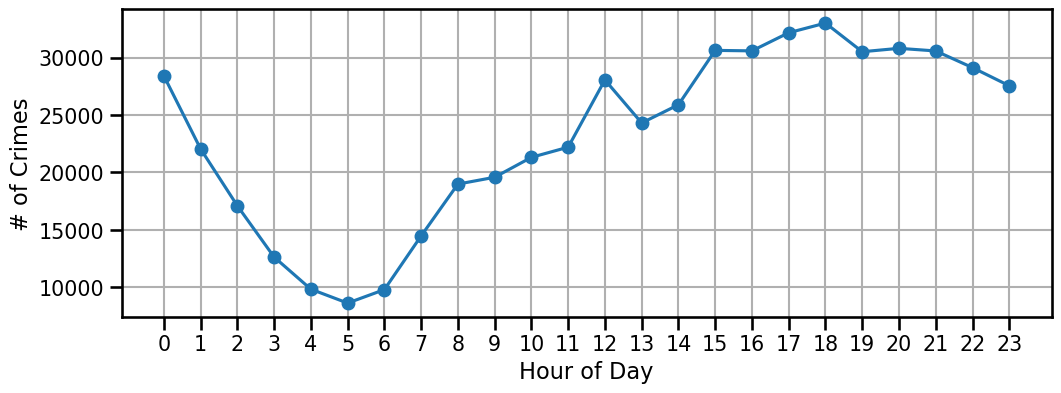

In [25]:
## save hour counts
hour_counts = df['HourOfDay'].value_counts().sort_index()
# year_counts = df.groupby("Year").size()
ax = hour_counts.plot(style='o-',grid=True,ylabel='# of Crimes', xlabel='Hour of Day',xticks=hour_counts.index);

As we can see above, the early morning/late night hours (between 2 AM and 7 AM) have the lowest amount of crime.

# Stakeholder Questions


## Intro
The goal of this lesson is to expose you to a variety of the types of questions you might need to address with a time series data set. As always, there are usually multiple ways to approach data science problems, so if you have a different idea, give it a try and see if it works. Of course, the possibility of questions is endless, but this lesson will help you understand a possible problem solving approach you might take to address different questions. As you go through the lesson, think of other questions that might be answered in a similar way. Try answering them on your own using variations of the strategies provided.

# Stakeholder Questions
1. What is the likelihood of each crime across hours of the day?
    1. For each crime, indicate when the crime is most likely to occur.
    2. and when it is least likely to occur.
2. What are the 3 most common crimes committed in December-January?
3. Are there crimes that are trending up/down? if you...:
    1. Calculate the change in crime counts from 2018 to 2021?
    2. What about as a % change?
4. Studying the effect of holidays: What crimes are most common on New Year's Day?
5. Are there more crimes on Thanksgiving than on any other Thursday in the dataset?
6. Which police district has the most crime overall?

# Q1) What is the likelihood of each crime across hours of the day?
We can group by Description and then take the value counts for Hour of the Day.
this will give us the # of crimes per hour for each type of crime.

In [28]:
## Get # of crimes by Hour
crimes_by_hour = df.groupby('Description')['HourOfDay'].value_counts().sort_index()
crimes_by_hour

Description   HourOfDay
AGG. ASSAULT  0            3608
              1            3436
              2            2744
              3            1896
              4            1340
                           ... 
SHOOTING      19            409
              20            432
              21            489
              22            530
              23            485
Name: HourOfDay, Length: 312, dtype: int64

Great! Let's try to plot this series.


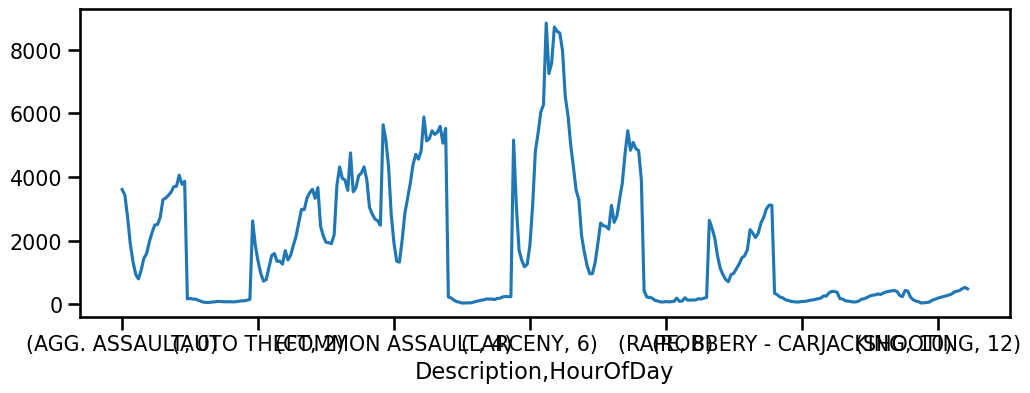

In [29]:
crimes_by_hour.plot();

As we can see, pandas did not really know how to handle our Series' MultiIndex.
Let's convert this to a dataframe (and let's call our value counts column '# of Crimes').
Then let's reset the index to convert the Series to a DataFrame.

In [30]:
## convert to dataframe and reset_index()
plot_df = crimes_by_hour.to_frame('# of Crimes').reset_index()
plot_df

,Description,HourOfDay,# of Crimes
0,AGG. ASSAULT,0,3608
1,AGG. ASSAULT,1,3436
2,AGG. ASSAULT,2,2744
3,AGG. ASSAULT,3,1896
4,AGG. ASSAULT,4,1340
...,...,...,...
307,SHOOTING,19,409
308,SHOOTING,20,432
309,SHOOTING,21,489
310,SHOOTING,22,530


Now that we have 1 column for the description, 1 column for the hour, and 1 column for the # of crimes, we can easily leverage seaborn visualizations.

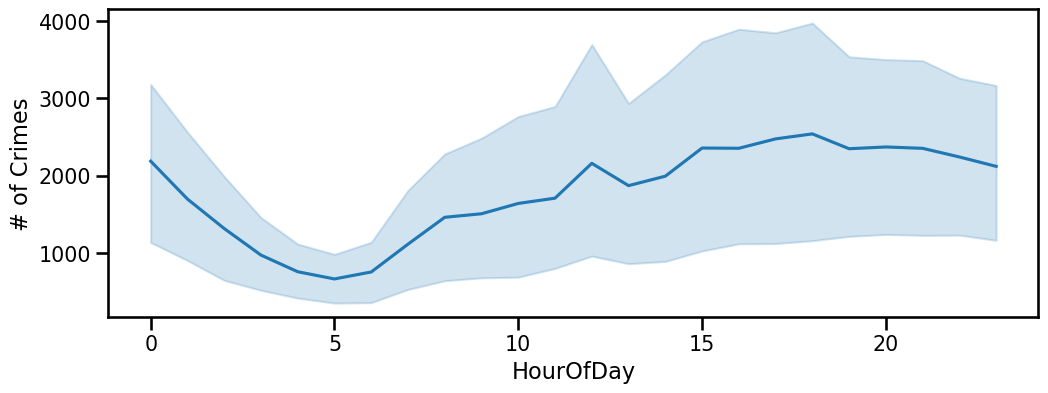

In [31]:
ax = sns.lineplot(data=plot_df, x='HourOfDay',y='# of Crimes')


We can see that overall there is a trend of fewer crimes occurring in the early morning the evening.
However, the error band is very wide and indicates there is likely a lot of variability between crimes.

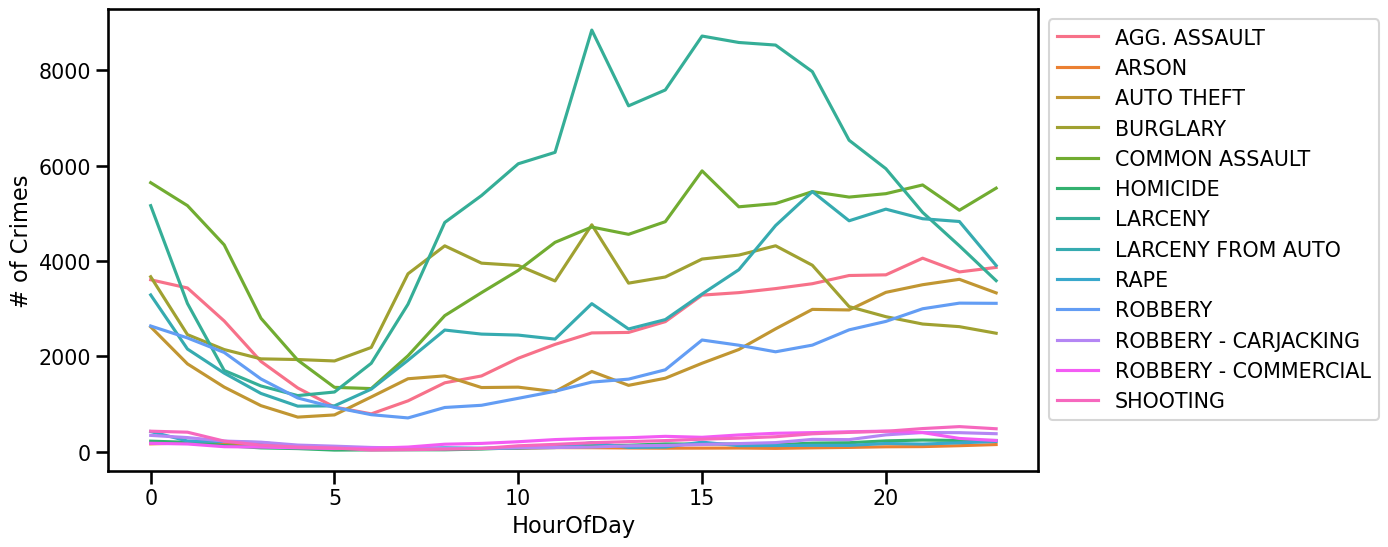

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=plot_df, x='HourOfDay',y='# of Crimes',markers=True,
                  hue='Description',ax=ax,)
ax.legend(bbox_to_anchor=[1,1]);

With all crimes using the same scale, it is very difficult to compare the pattern of the crimes that are not as frequent (anything lesson than 1,000 crimes per hour).
If we shift to use a fancier seaborn plotting function, we can easily break each crime into its own plot.
We will use seaborn's catplot, which can produce many different kinds of figures.
Documentation for Catplot
We are already using the hue argument to give a separate line to each crime. We can also specify col='Description', which will produce a separate subplot for each category in the provided column name.
If we check the documentation, we will see that catplot has a sharex and sharey argument, which are both set to True by default. Let's set them to False so that each crime gets its own x-axis and y-axis.

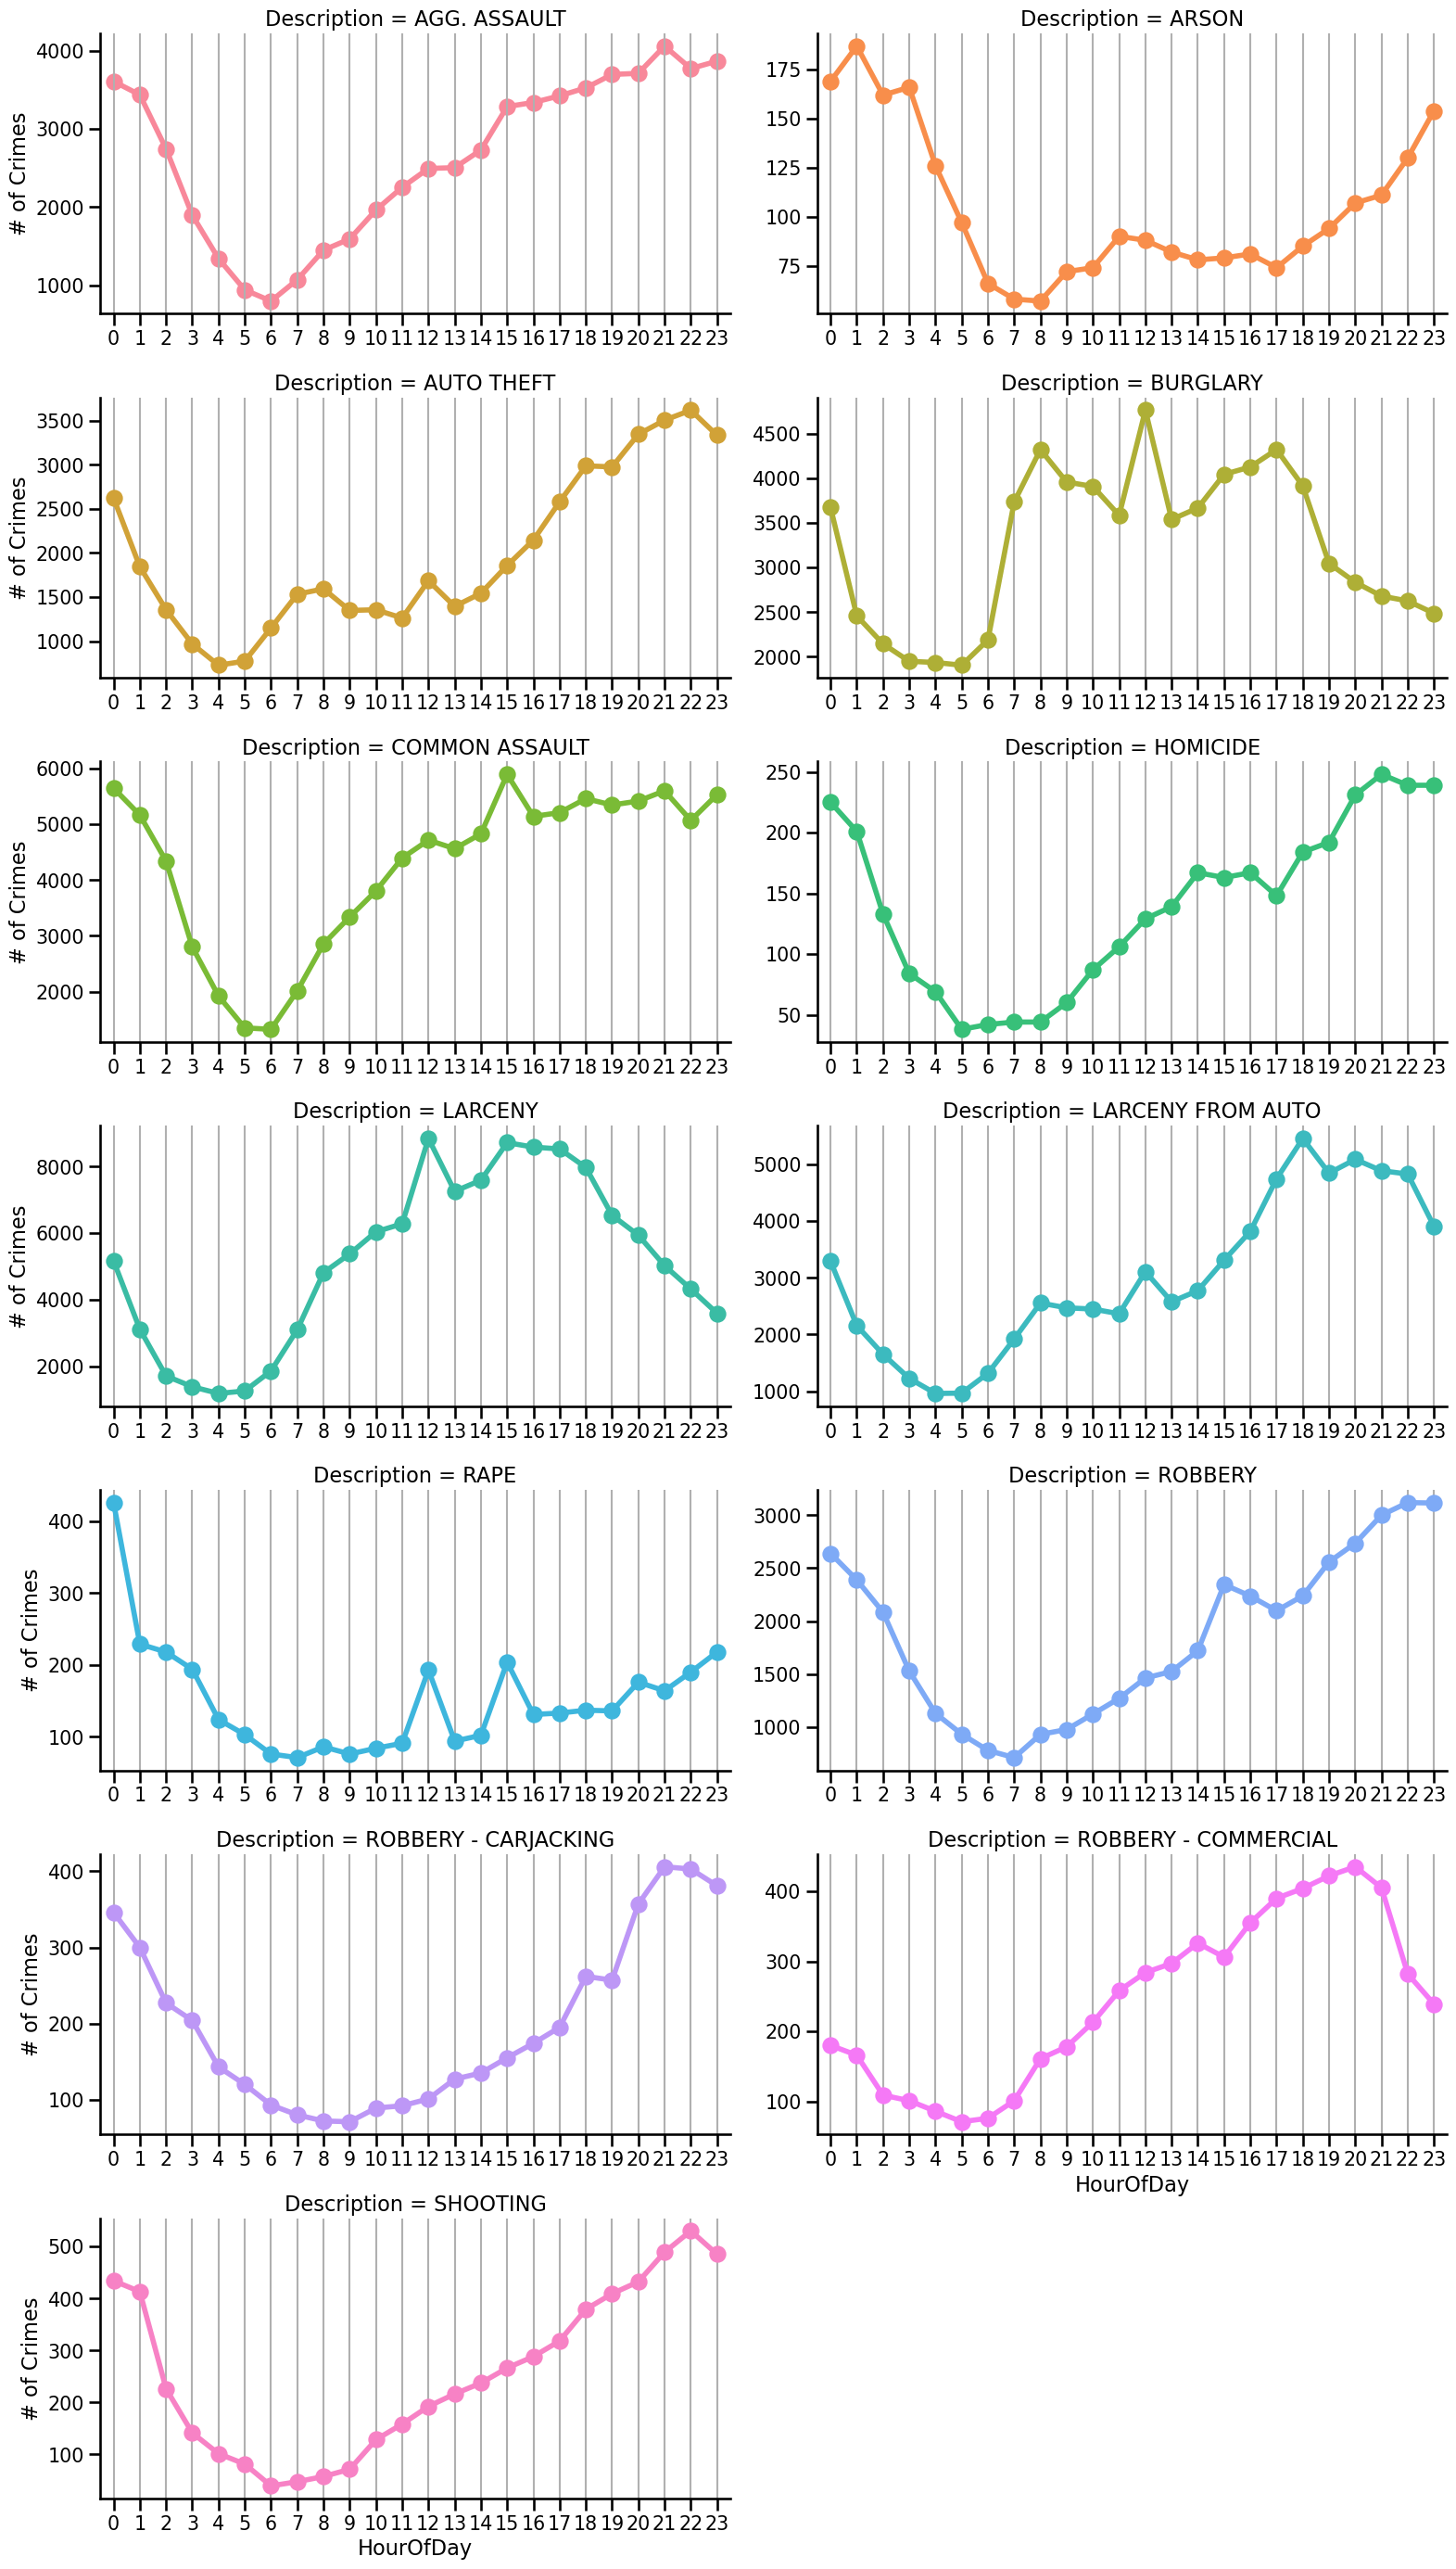

In [33]:
g = sns.catplot(data=plot_df, x='HourOfDay', y='# of Crimes',
                kind='point',aspect=2, height=4,
                hue='Description', col='Description',col_wrap=2,
               sharey=False, sharex=False)
[ax.grid(axis='x') for ax in g.axes];

As we can see above, most crimes follow a U-shaped curve with the highest number of crimes committed during the night/early morning.
However, this is not the case for every crime:
Burglary
Rape
Common Assault
Larceny
## Normalizing by Percent
Our stakeholders wanted to know when each crime was most and least likely.
The cleanest way to compare this is to convert the raw counts into % for each hour of the day.
Let's add the normalize=True argument to value_counts and visualize again.

In [34]:
crime_perc_by_hour = df.groupby('Description')['HourOfDay'].value_counts(normalize=True).sort_index()
crime_perc_by_hour

Description   HourOfDay
AGG. ASSAULT  0            0.056824
              1            0.054115
              2            0.043217
              3            0.029861
              4            0.021104
                             ...   
SHOOTING      19           0.066645
              20           0.070393
              21           0.079681
              22           0.086361
              23           0.079029
Name: HourOfDay, Length: 312, dtype: float64

In [35]:
## Convert to dataframe and reset index
plot_df_perc = crime_perc_by_hour.to_frame('# of Crimes').reset_index()
plot_df_perc

,Description,HourOfDay,# of Crimes
0,AGG. ASSAULT,0,0.056824
1,AGG. ASSAULT,1,0.054115
2,AGG. ASSAULT,2,0.043217
3,AGG. ASSAULT,3,0.029861
4,AGG. ASSAULT,4,0.021104
...,...,...,...
307,SHOOTING,19,0.066645
308,SHOOTING,20,0.070393
309,SHOOTING,21,0.079681
310,SHOOTING,22,0.086361


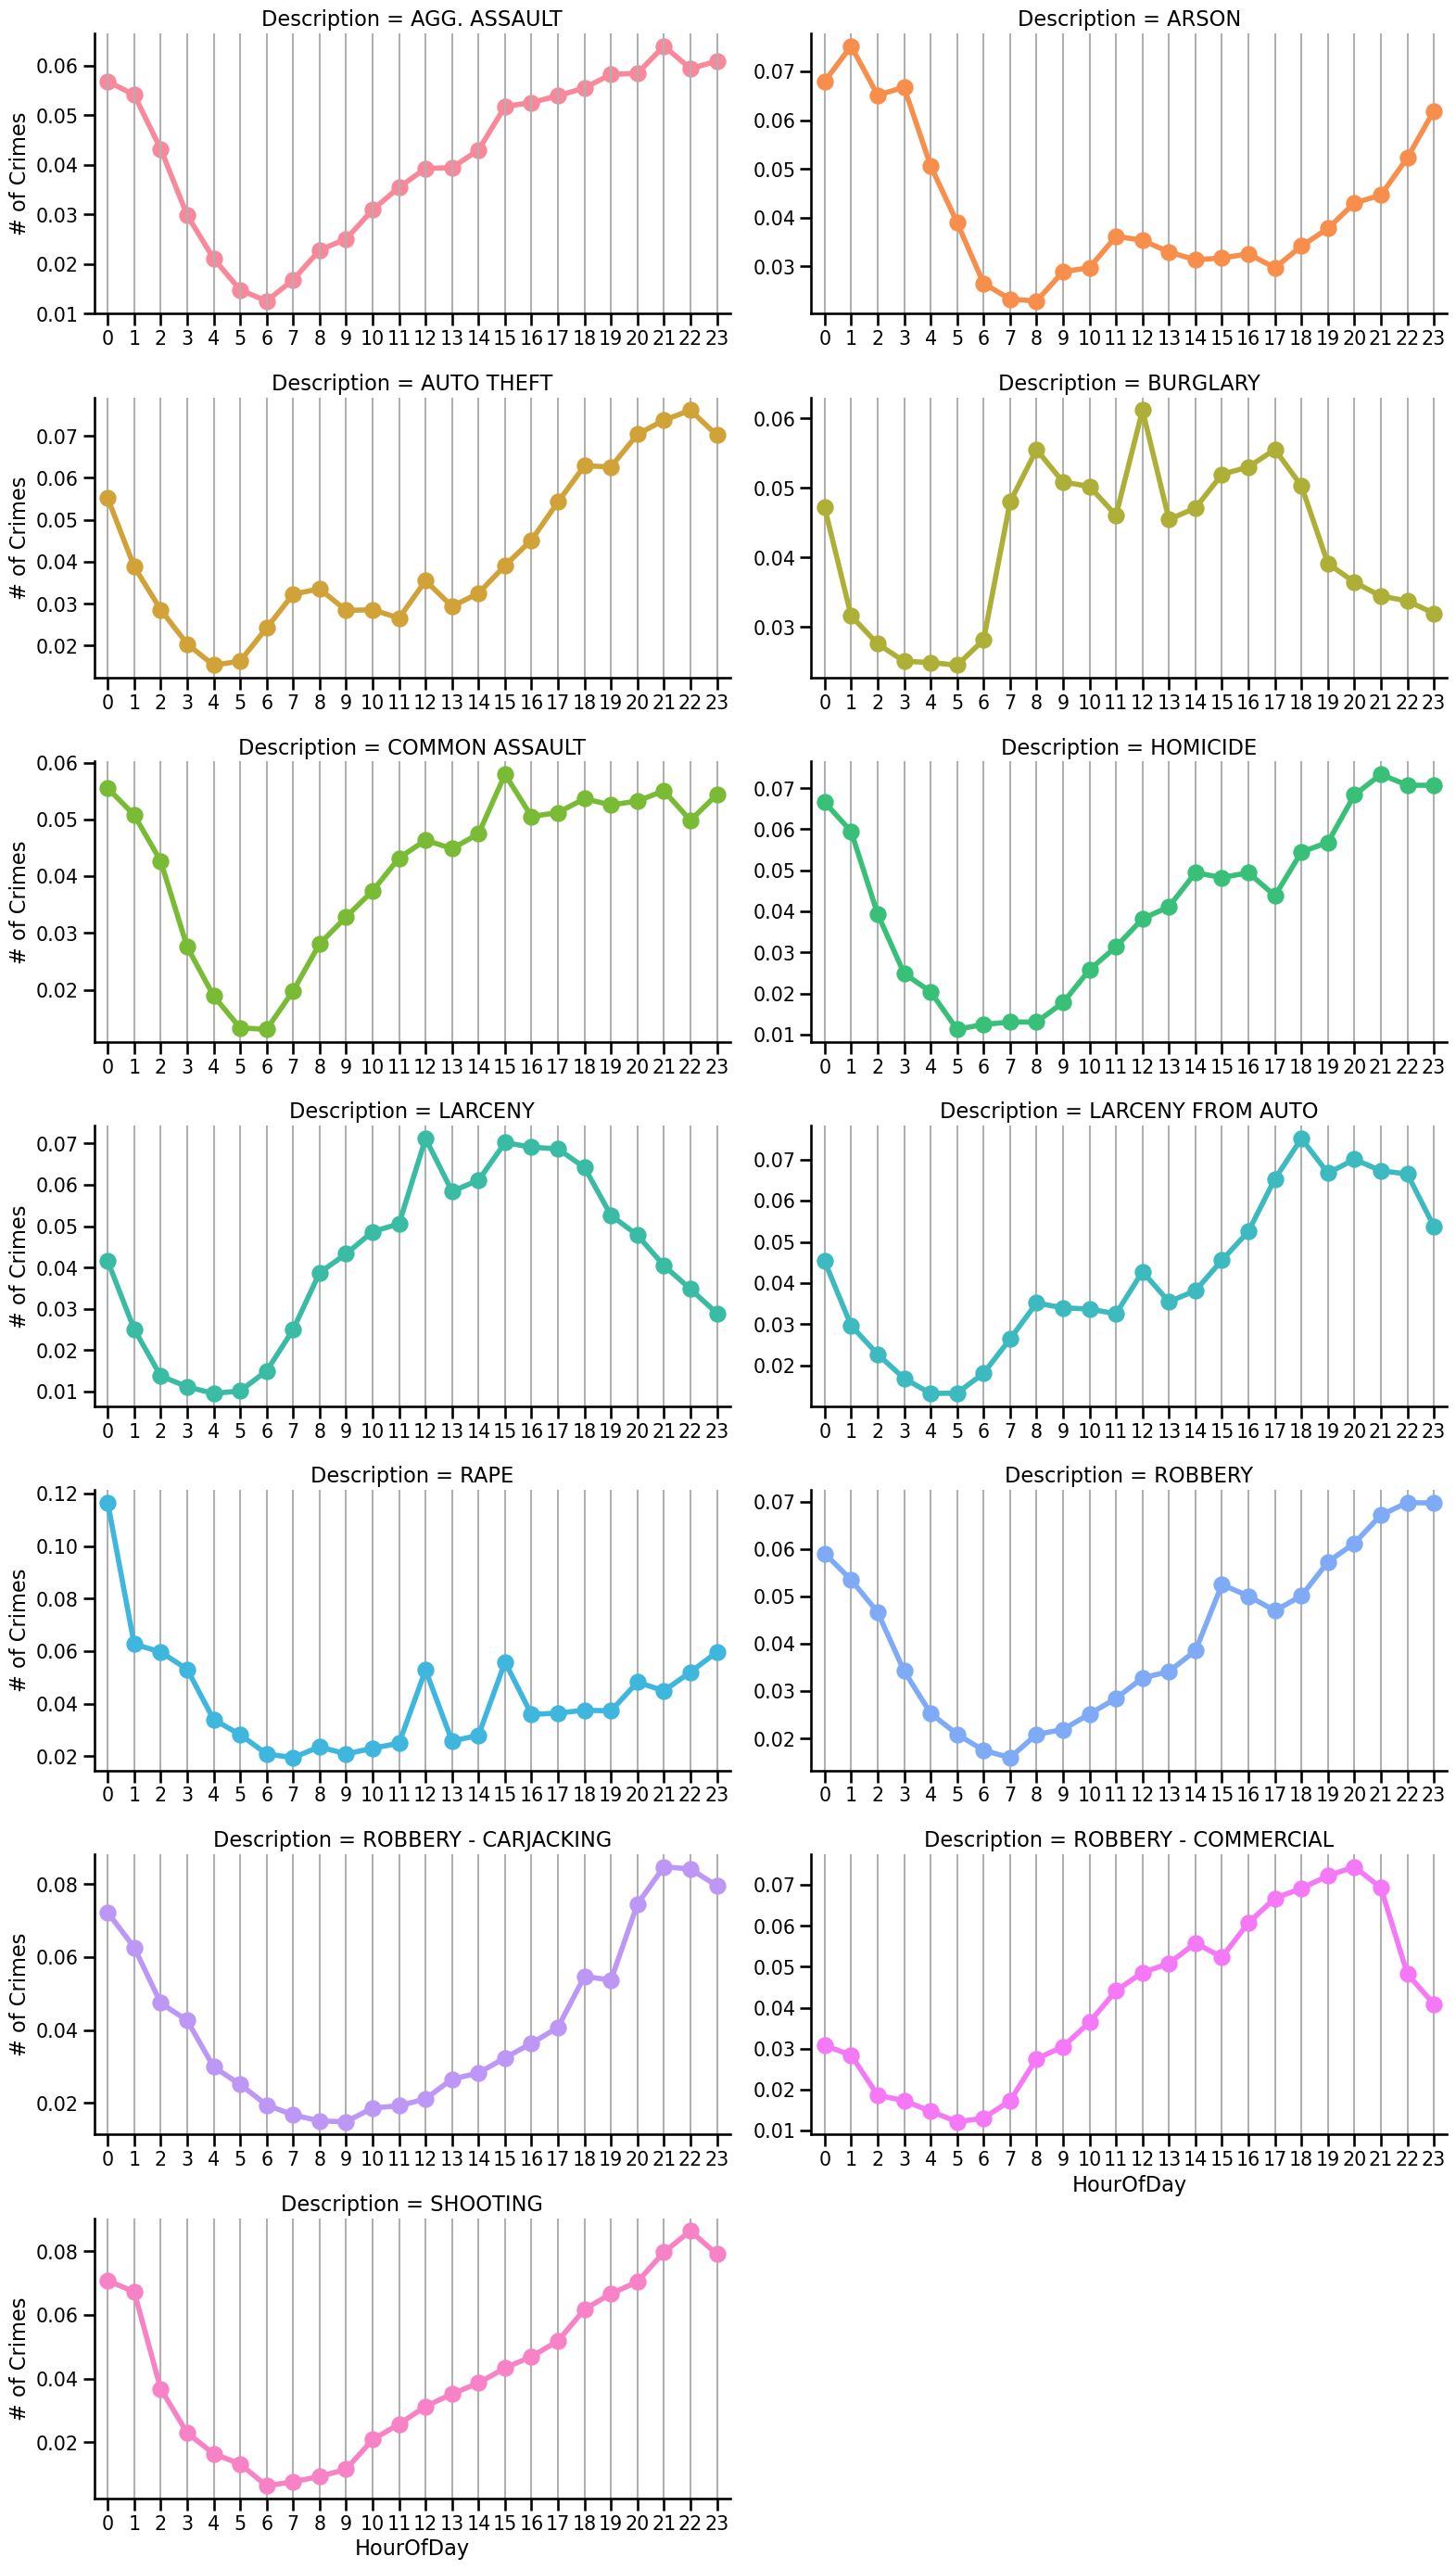

In [36]:
g = sns.catplot(data=plot_df_perc, x='HourOfDay', y='# of Crimes',
                hue='Description', col='Description',col_wrap=2,
            aspect=2, height=4,
           kind='point',sharey=False,sharex=False);
[ax.grid(axis='x') for ax in g.axes];

Normalizing allows each of the crimes to have the same scale for easier comparisons.

### Getting Numeric Answers to Questions

Our visualization is easy to read but it is still asking a lot of the viewer to manually inspect and identify the highest and lowest point for each crime.
Let's leverage our pandas and visualization skills to annotate the actual highest and lowest crime hours.
### Getting the Hours of Day with the min and max crimes for each type
### Looping through the groupby value counts

In [37]:
# looping through the value counts series
val_counts_by_hour = df.groupby('Description')['HourOfDay'].value_counts()
val_counts_by_hour

Description   HourOfDay
AGG. ASSAULT  21           4060
              23           3867
              22           3772
              20           3711
              19           3697
                           ... 
SHOOTING      5              81
              9              71
              8              57
              7              47
              6              39
Name: HourOfDay, Length: 312, dtype: int64

In [38]:
## Getting all of the crimes from the first level of the index
crime_list = val_counts_by_hour.index.levels[0]
crime_list

Index(['AGG. ASSAULT', 'ARSON', 'AUTO THEFT', 'BURGLARY', 'COMMON ASSAULT',
       'HOMICIDE', 'LARCENY', 'LARCENY FROM AUTO', 'RAPE', 'ROBBERY',
       'ROBBERY - CARJACKING', 'ROBBERY - COMMERCIAL', 'SHOOTING'],
      dtype='object', name='Description')

In [39]:
##selecting a test crime and slicing the result
crime='HOMICIDE'
val_counts_by_hour.loc[crime]

HourOfDay
21    248
22    239
23    239
20    231
0     225
1     201
19    192
18    184
14    167
16    167
15    163
17    148
13    139
2     133
12    129
11    106
10     87
3      84
4      69
9      60
7      44
8      44
6      42
5      38
Name: HourOfDay, dtype: int64

We can also use .agg and get the min and max!


In [40]:
## getting min and max values
val_counts_by_hour.loc[crime].agg(['min','max'])

min     38
max    248
Name: HourOfDay, dtype: int64

Or we can go straight to getting the index of the min and max with idxmin/idxmax.


In [41]:
##  Getting indices for min and max
val_counts_by_hour.loc[crime].agg(['idxmin','idxmax'])

idxmin     5
idxmax    21
Name: HourOfDay, dtype: int64

We will apply this approach inside our loop through the facet grid.
## Annotating the Min and Max Hours for Each Crime

Now, we will annotate our previous catplot using this information.
For each crime, we want to:
Get the correct subplot Axis for the current crime crime
Get the min and max hours for the current crime from our min_max dataframe.
Add 2 vertical lines (axvlines) for the min and max.
Add a legend with the min and max annotated for each plot.
e.g. "Min (Hour=4)"
- First, we will recreate our figure and save the FacetGrid that is returned by catplot as g (standard name for a facetgrid).
- FacetGrid's store:
the matplotlib axes under g.axes
the columns for each ax under g.col_names
They are both stored in order of the subplots, so the first Axis is for the first col_name.
There is also a dictionary of {'col name':axis} under .axes_dict

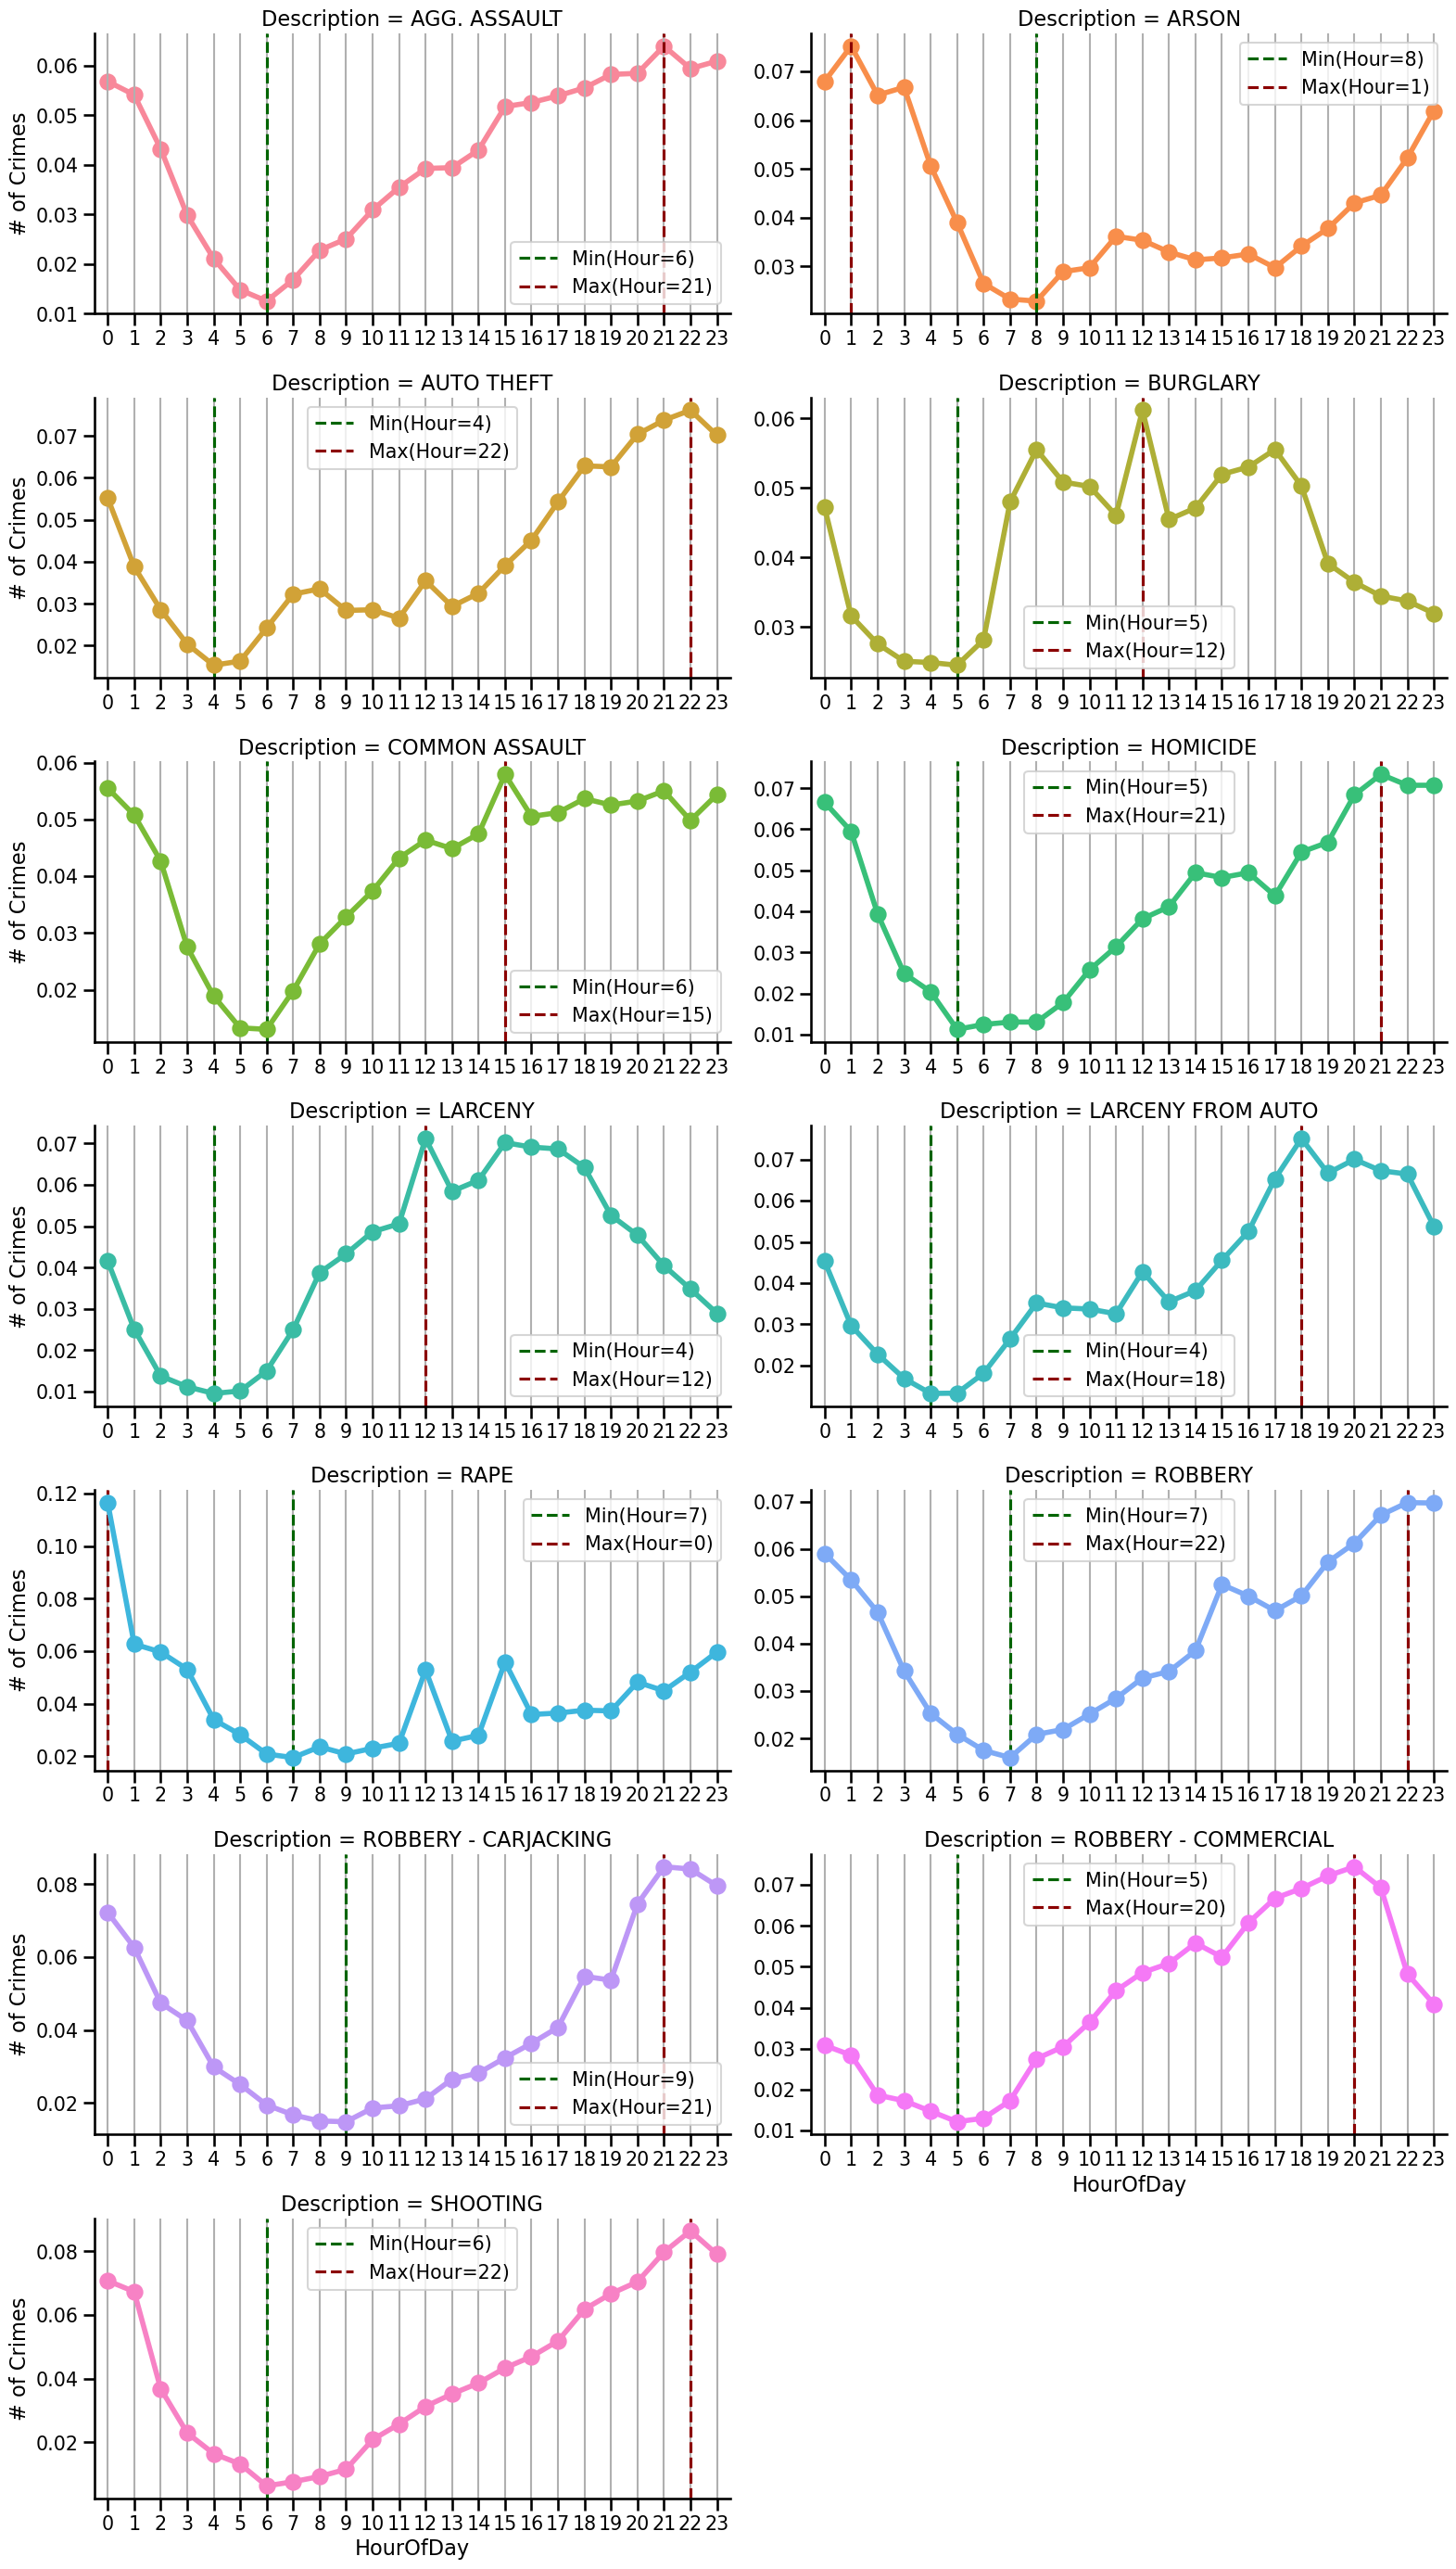

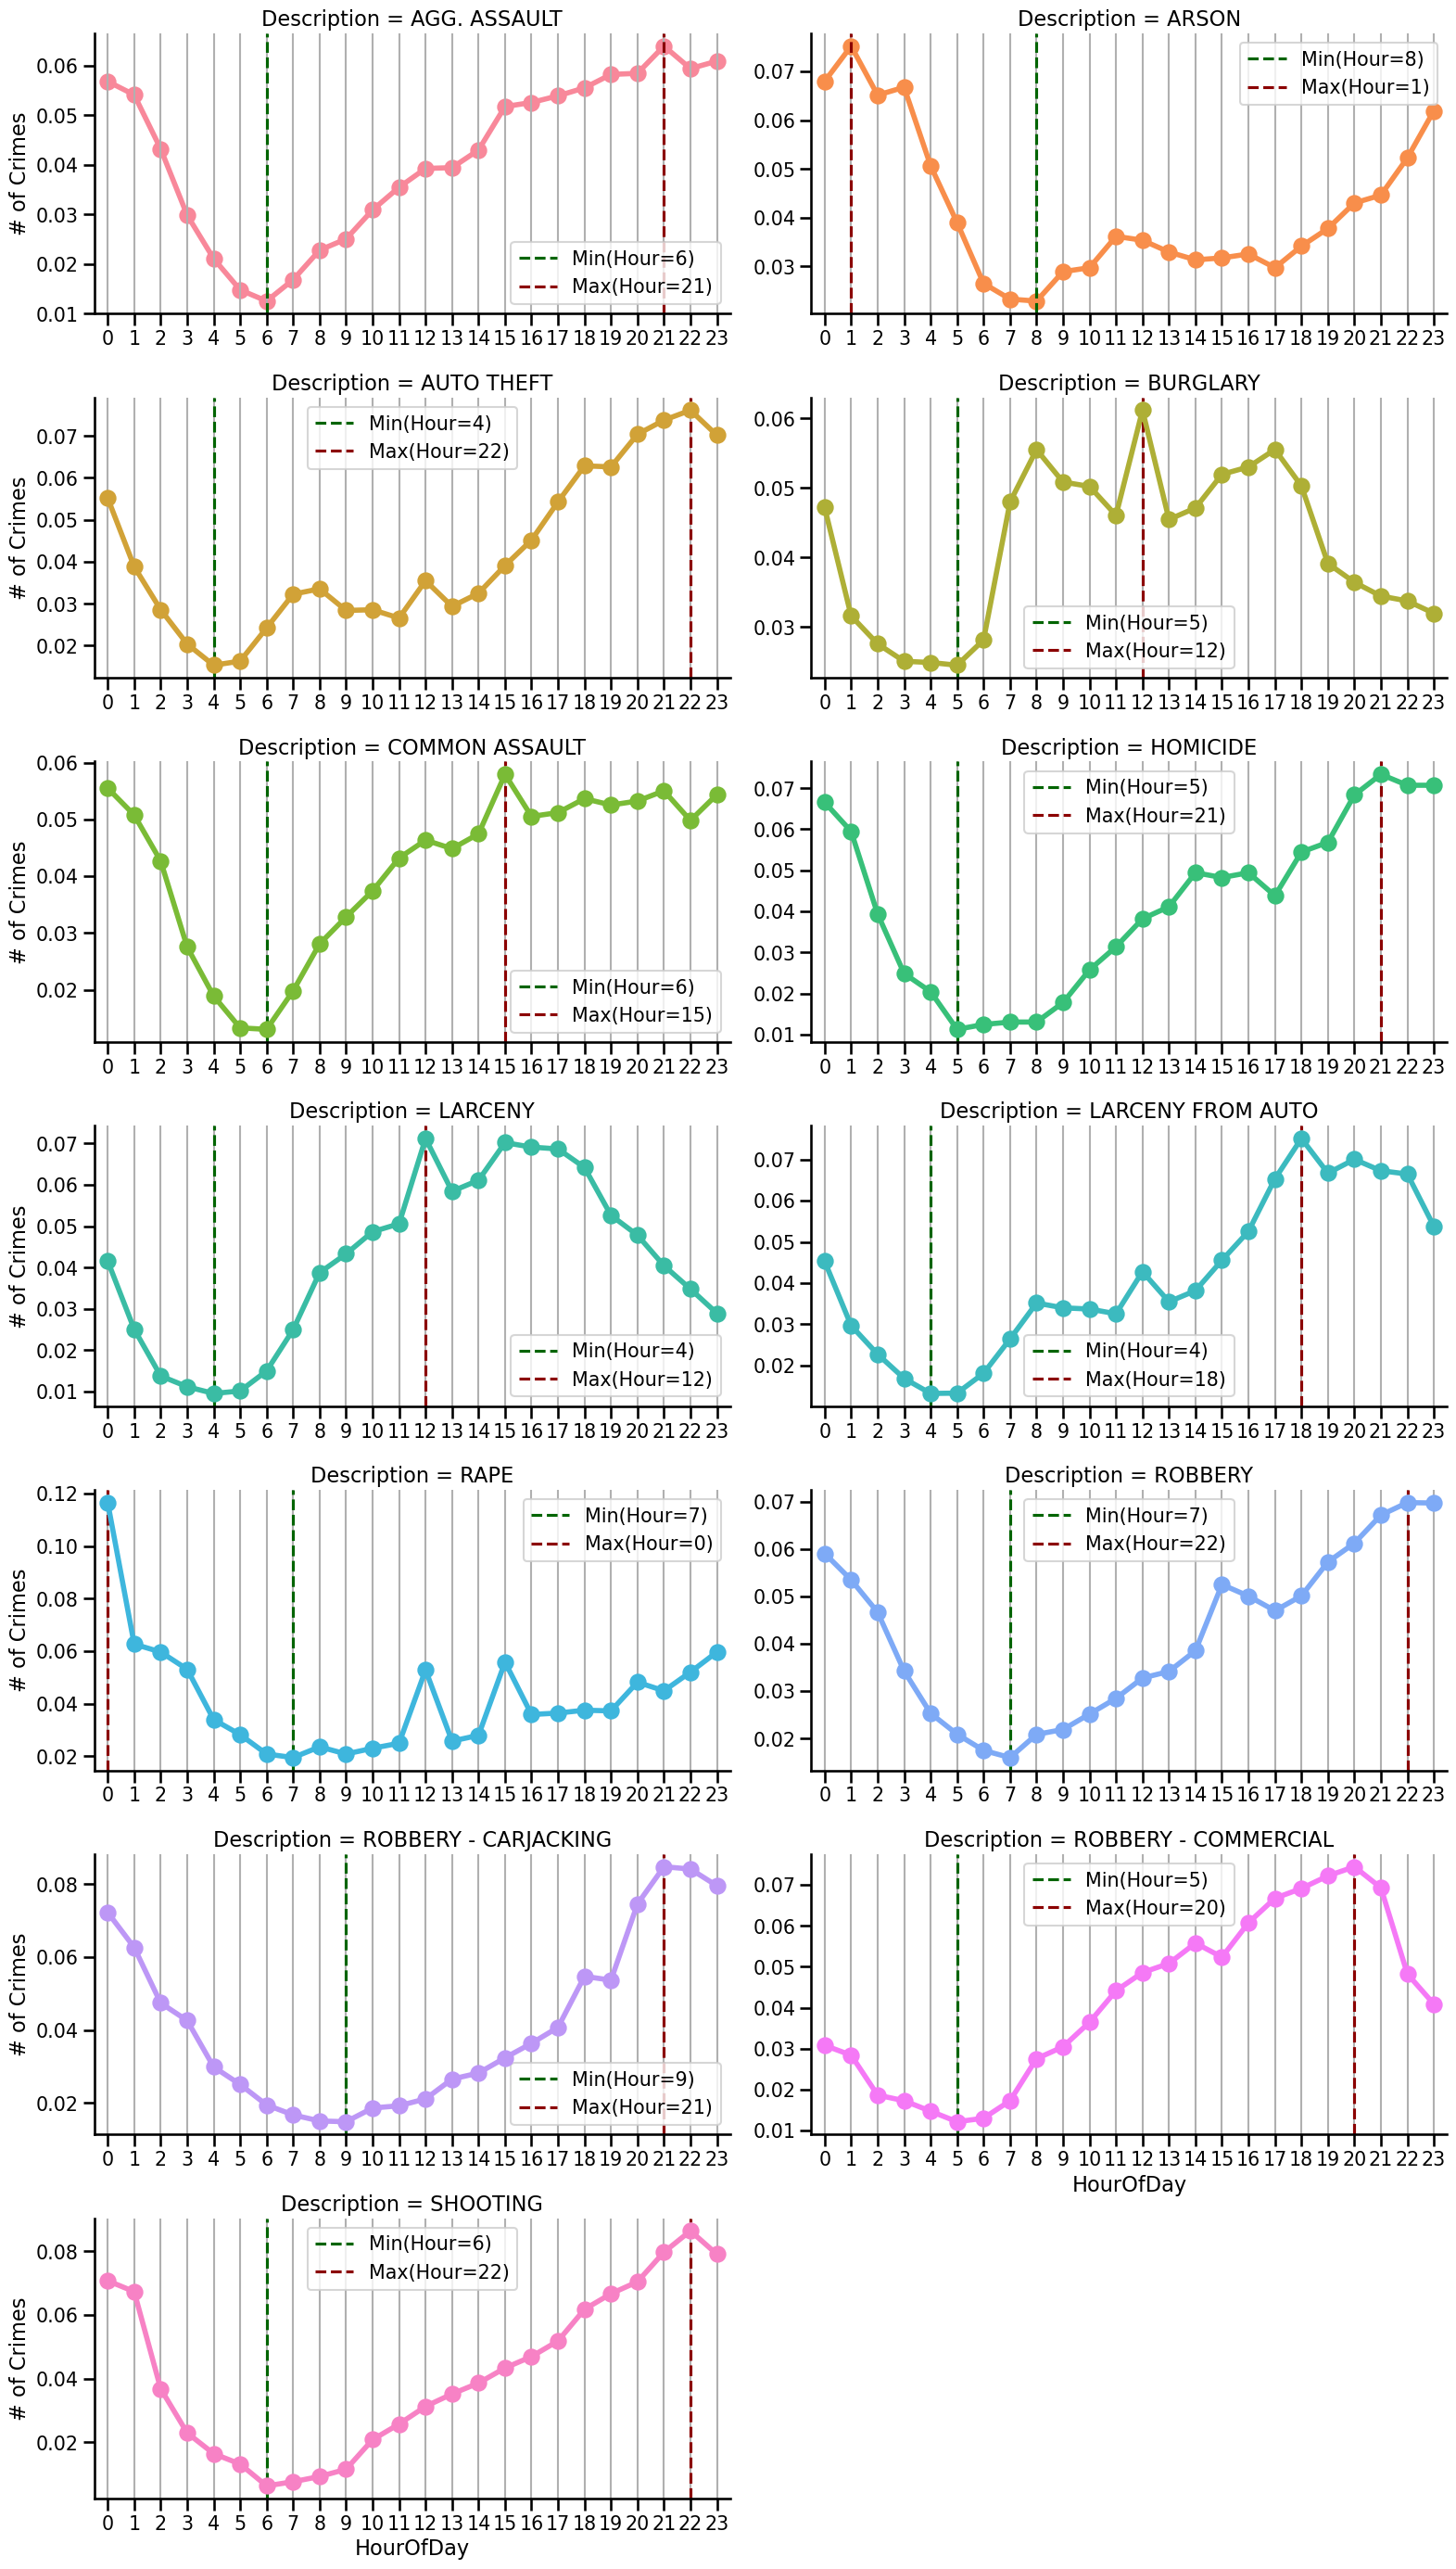

In [42]:
g = sns.catplot(data=plot_df_perc, x='HourOfDay', y='# of Crimes',
                hue='Description', col='Description',col_wrap=2,
            aspect=2, height=4,
           kind='point',sharey=False,sharex=False);
## loop throught the axes dict
for col, ax in g.axes_dict.items():
    
    ## Extract the idx min and idxmax from the val counts
    min_, max_ = val_counts_by_hour.loc[col].agg(['idxmin','idxmax'])
    
    ## add vlines for both and SAVE THE LINE and a label to use in legend
    ln1 = ax.axvline(min_, color='darkgreen',ls='--')
    lab1 = f'Min(Hour={min_})'
    
    ln2 = ax.axvline(max_,color='darkred',ls='--')
    lab2 = f'Max(Hour={max_})'
    
    ## manually add legend using list of ln1 and ln2 and a list of labels
    ax.legend( [ln1,ln2], [lab1,lab2] )
    ## add x grid
    ax.grid(axis='x')
    
g.fig

We can see our visualization has the annotated answer for each crime, with the numeric value in the legend for "at a glance" interpretation.


# Q2) What are the 3 most common crimes committed in:
December-January?

In [44]:
crimes_by_month = df.groupby("Month")['Description'].value_counts(normalize=False)
crimes_by_month

Month  Description         
1      LARCENY                 9798
       COMMON ASSAULT          8094
       BURGLARY                6497
       LARCENY FROM AUTO       5777
       AGG. ASSAULT            4882
                               ... 
12     SHOOTING                 492
       ROBBERY - CARJACKING     383
       HOMICIDE                 279
       RAPE                     251
       ARSON                    173
Name: Description, Length: 156, dtype: int64

In [45]:
jan_dec_crimes = crimes_by_month.loc[1] + crimes_by_month.loc[12]
jan_dec_crimes

Description
AGG. ASSAULT             9489
ARSON                     353
AUTO THEFT               8283
BURGLARY                13316
COMMON ASSAULT          15921
HOMICIDE                  565
LARCENY                 19845
LARCENY FROM AUTO       11630
RAPE                      558
ROBBERY                  7774
ROBBERY - CARJACKING      836
ROBBERY - COMMERCIAL     1124
SHOOTING                  928
Name: Description, dtype: int64

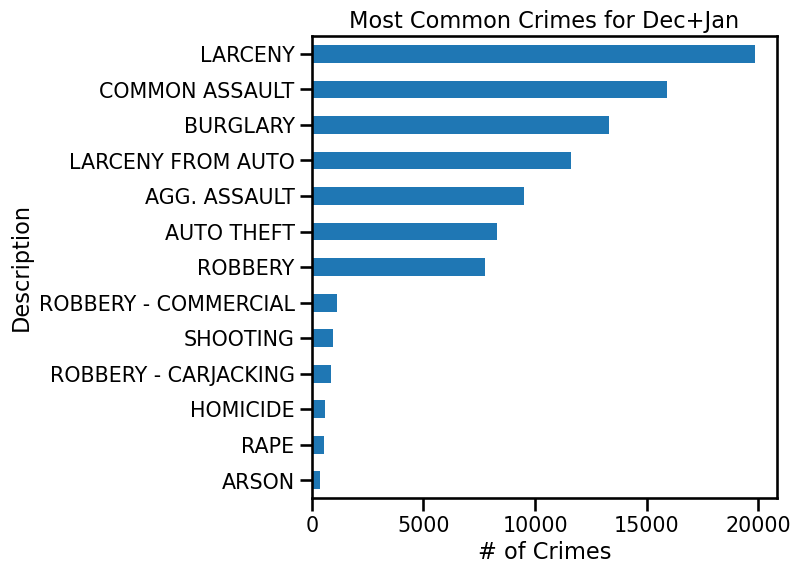

In [46]:
ax = jan_dec_crimes.sort_values().plot(kind='barh',figsize=(6,6))
ax.set(title='Most Common Crimes for Dec+Jan',xlabel='# of Crimes');

We can see that the 3 most common crimes during the months of December and January are:
Larceny
Common Assault
Burglary


# Q3) Are there crimes that are trending up/down? if you...:
Calculate the change in crime counts from 2018 to 2021?

In [47]:
## First, resample the data as annual 
df_year  = df.groupby('Description').resample('A').sum()['Total_Incidents'].reset_index()
df_year

/var/folders/l7/w6kg6nmd3dgfd2wj06wwdb1c0000gn/T/ipykernel_83306/1448304134.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = df.groupby('Description').resample('A').sum()['Total_Incidents'].reset_index()
/var/folders/l7/w6kg6nmd3dgfd2wj06wwdb1c0000gn/T/ipykernel_83306/1448304134.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year  = df.groupby('Description').resample('A').sum()['Total_Incidents'].reset_index()
/var/folders/l7/w6kg6nmd3dgfd2wj06wwdb1c0000gn/T/ipykernel_83306/1448304134.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a futur

,Description,CrimeDateTime,Total_Incidents
0,AGG. ASSAULT,2011-12-31,5117
1,AGG. ASSAULT,2012-12-31,4865
2,AGG. ASSAULT,2013-12-31,4602
3,AGG. ASSAULT,2014-12-31,4259
4,AGG. ASSAULT,2015-12-31,4740
...,...,...,...
162,SHOOTING,2019-12-31,766
163,SHOOTING,2020-12-31,721
164,SHOOTING,2021-12-31,726
165,SHOOTING,2022-12-31,688


In [48]:
## can pivot the result to have the datetime as the index and the crime as the columns
years_ts = df_year.pivot(index='CrimeDateTime',columns='Description')
years_ts.head()

Total_Incidents                                            \
Description      AGG. ASSAULT  ARSON AUTO THEFT BURGLARY COMMON ASSAULT   
CrimeDateTime                                                             
2011-12-31             5117.0  297.0     3766.0   8756.0         9463.0   
2012-12-31             4865.0  243.0     3543.0   7875.0         9258.0   
2013-12-31             4602.0  273.0     3804.0   7462.0         8467.0   
2014-12-31             4259.0  216.0     3649.0   6867.0         7453.0   
2015-12-31             4740.0  292.0     4562.0   7827.0         6984.0   

                                                                  \
Description   HOMICIDE  LARCENY LARCENY FROM AUTO   RAPE ROBBERY   
CrimeDateTime                                                      
2011-12-31         NaN  10037.0            7321.0  315.0  3407.0   
2012-12-31       216.0  10768.0            7041.0  318.0  3528.0   
2013-12-31       235.0  12315.0            6756.0  276.0  3744.0   
2014-12-31       211.0  11337.0            6716.0  246.0  3237.0   
2015-12-31       342.0  10640.0            7047.0  287.0  3766.0   

                                                                  
Description   ROBBERY - CARJACKING ROBBERY - COMMERCIAL SHOOTING  
CrimeDateTime                                                     
2011-12-31                   192.0                294.0      NaN  
2012-12-31                   182.0                277.0     28.0  
2013-12-31                   122.0                231.0     43.0  
2014-12-31                   155.0                513.0    369.0  
2015-12-31                   284.0                669.0    632.0

Our pivot created a MutiIndex for columns, which will be cumbersome to deal with.


In [49]:
years_ts.columns

MultiIndex([('Total_Incidents',         'AGG. ASSAULT'),
            ('Total_Incidents',                'ARSON'),
            ('Total_Incidents',           'AUTO THEFT'),
            ('Total_Incidents',             'BURGLARY'),
            ('Total_Incidents',       'COMMON ASSAULT'),
            ('Total_Incidents',             'HOMICIDE'),
            ('Total_Incidents',              'LARCENY'),
            ('Total_Incidents',    'LARCENY FROM AUTO'),
            ('Total_Incidents',                 'RAPE'),
            ('Total_Incidents',              'ROBBERY'),
            ('Total_Incidents', 'ROBBERY - CARJACKING'),
            ('Total_Incidents', 'ROBBERY - COMMERCIAL'),
            ('Total_Incidents',             'SHOOTING')],
           names=[None, 'Description'])

We can use df.columns.droplevel() with an index for which level of columns to drop.


In [50]:
years_ts.columns = years_ts.columns.droplevel(0)
years_ts.columns

Index(['AGG. ASSAULT', 'ARSON', 'AUTO THEFT', 'BURGLARY', 'COMMON ASSAULT',
       'HOMICIDE', 'LARCENY', 'LARCENY FROM AUTO', 'RAPE', 'ROBBERY',
       'ROBBERY - CARJACKING', 'ROBBERY - COMMERCIAL', 'SHOOTING'],
      dtype='object', name='Description')

This returns JUST the inner list of crime names, what we want to be our column names.



## Q3A) Calculating Change in crimes from 2018 to 2021
To get the change, we will slice data from 2021 and 2018 and subtract to obtain the difference:

In [51]:
## Substract to get delta crmes
delta_crime_yrs = years_ts.loc['2021'] - years_ts.loc['2018']
delta_crime_yrs

Description,AGG. ASSAULT,ARSON,AUTO THEFT,BURGLARY,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,SHOOTING
CrimeDateTime,,,,,,,,,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Oh no! We got all Nans. What went wrong?
When we sliced out the years we did not get a Pandas Series, but got a single-row dataframe.
Pandas is confused by us subtracting 2 dataframes.
To fix this:
We can slice the exact date on the index (including the month and day) to get a Series for each year.

In [53]:
### Substract to get delta crmes
delta_crime_yrs = years_ts.loc['2021-12-31'] - years_ts.loc['2018-12-31']
delta_crime_yrs

Description
AGG. ASSAULT             -96.0
ARSON                     12.0
AUTO THEFT             -1034.0
BURGLARY               -2761.0
COMMON ASSAULT          -219.0
HOMICIDE                  25.0
LARCENY                -3487.0
LARCENY FROM AUTO      -1798.0
RAPE                     -75.0
ROBBERY                -1465.0
ROBBERY - CARJACKING      98.0
ROBBERY - COMMERCIAL    -469.0
SHOOTING                  49.0
dtype: float64

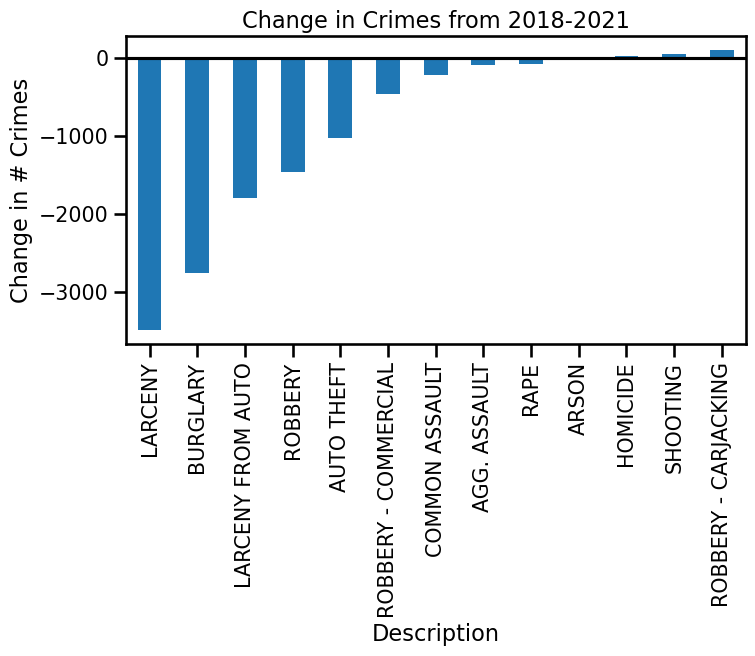

In [54]:
ax = delta_crime_yrs.sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='Change in # Crimes',
                                       title='Change in Crimes from 2018-2021')
ax.axhline(0,color='k');

We can see above that the majority of crimes have decreased between 2018 and 2021.
Shootings and Robbery-Carjacking are the exceptions. They both increased.
Remember: some crimes have a MUCH higher occurrence and can make it difficult to observe changes in the crimes with smaller counts.
## Q3B) What if we wanted to see this as a relative change instead of total counts?
After calculating the change in crime COUNTS, we can then divide by the counts from 2018 so that we are looking at the RATIO of the change in crimes (instead of counts).
We can multiply this by 100 to get the percentage change.

In [55]:
## Substract to get delta crmes
delta_crime_perc = (delta_crime_yrs/ years_ts.loc['2018-12-31'])*100
delta_crime_perc.sort_values()

Description
ROBBERY - COMMERCIAL   -74.326466
BURGLARY               -44.403345
ROBBERY                -33.265213
LARCENY                -32.555317
LARCENY FROM AUTO      -28.195076
AUTO THEFT             -24.513988
RAPE                   -20.547945
COMMON ASSAULT          -2.592330
AGG. ASSAULT            -1.704848
SHOOTING                 7.237814
HOMICIDE                 8.090615
ARSON                    9.448819
ROBBERY - CARJACKING    20.289855
dtype: float64

In [56]:
from matplotlib import ticker

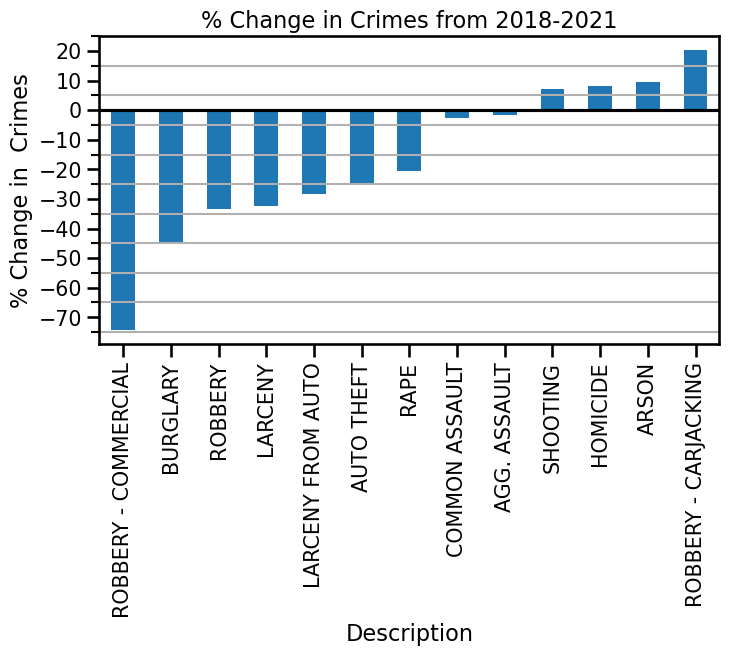

In [99]:
ax = delta_crime_perc.sort_values().plot(kind='bar',figsize=(8,4),
                                       ylabel='% Change in  Crimes',
                                       title='% Change in Crimes from 2018-2021')
ax.axhline(0,color='k');
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.grid(axis='y',which='minor')
# ax.grid(axis='y',which='major',color='darkgray')

The % change in crimes doesn't look as positive as the raw counts.
We can see that Shootings, Homicides, Arson, and Carjackings have all increased by ~8% and carjackings are up by 20%.
# Q4) What crimes are most common on New Year's Day?

In [117]:
from holidays import country_holidays

us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [ ]:
## adding day of week and holiday features to daily_df
daily_df['DayOfWeek'] = daily_df.index.day_name()
daily_df['US Holiday']  = daily_df.index.map(us_holidays.get)
daily_df["Holiday"] = daily_df["Holiday"].fillna("None")
daily_df.head()

In [104]:
holiday_crimes = df.groupby('US Holiday')['Description'].value_counts()
holiday_crimes = holiday_crimes.to_frame('# of Crimes')#.reset_index()
holiday_crimes

# of Crimes
US Holiday Description                      
False      LARCENY                    121075
           COMMON ASSAULT              98645
           BURGLARY                    75639
           LARCENY FROM AUTO           70689
           AGG. ASSAULT                61664
           AUTO THEFT                  46265
           ROBBERY                     43439
           SHOOTING                     5948
           ROBBERY - COMMERCIAL         5699
           ROBBERY - CARJACKING         4657
           RAPE                         3499
           HOMICIDE                     3290
           ARSON                        2406
True       LARCENY                      3041
           COMMON ASSAULT               3034
           BURGLARY                     2147
           LARCENY FROM AUTO            1965
           AGG. ASSAULT                 1830
           AUTO THEFT                   1247
           ROBBERY                      1210
           SHOOTING                      189
           RAPE                          157
           ROBBERY - COMMERCIAL          146
           ROBBERY - CARJACKING          133
           HOMICIDE                       89
           ARSON                          81

In [105]:
## checking the values of the index (outer index is level 0)
holiday_crimes.index.levels[0]

Index([False, True], dtype='bool', name='US Holiday')

We can see above that many holidays have 2 versions: the actual holiday and the day it observed.
You would want to discuss with your stakeholder how they preferred you handle this. In our case, we are going to combine any crimes on the actual day with the observed day.
## New Years Day
Let's filter so we only have crimes committed on New Year' Day:

In [106]:
holiday_crimes.loc["New Year's Day"]

KeyError: "New Year's Day"

We will also filter for any crimes on New Year's Day (observed).


In [107]:
holiday_crimes.loc["New Year's Day (Observed)"]

KeyError: "New Year's Day (Observed)"

Remember, this would be a question to discuss with your stakeholder, but in our case, we want the sum of crimes on New Year's day and New Year's Day (Observed). Below we will try to simply add them with the + operator:


In [108]:
## let's try simply adding them
holiday_crimes.loc["New Year's Day"] + holiday_crimes.loc["New Year's Day (Observed)"]

KeyError: "New Year's Day"

Since arson was missing from one of the days, Pandas returned NaN instead of assuming a 0.
To fix this, let's combine the holidays as 2 columns side by side and then take the sum.

In [109]:
temp = pd.concat([holiday_crimes.loc["New Year's Day"],
                  holiday_crimes.loc["New Year's Day (Observed)"]],
                 axis=1)
temp

KeyError: "New Year's Day"

Now we will sum these two columns:

In [110]:
## get the .sum ACROSS columns (use axis=1)
new_years_sum = temp.sum(axis=1)
new_years_sum

NameError: name 'temp' is not defined

In [111]:
ax = new_years_sum.sort_values().plot(kind='barh',figsize=(8,6))
ax.set(title="New Years Day Crimes", xlabel='# of Crimes');

NameError: name 'new_years_sum' is not defined

# Q5) Are there more crimes on thanksgiving than any other Thursday in the dataset?
Thanksgiving Vs Thursdays
We first want to get our data resampled as daily data so we can track any Thursdays that may have had 0 crimes.
We are going to combine several steps we have done separately into one cell, but do not be alarmed! You have seen all of this before.
To ensure your understanding, you could run each of these steps separately and inspect the df after each step

In [112]:
daily_df = df.groupby('Description').resample('D').sum()['Total_Incidents'].reset_index()
daily_df = daily_df.pivot(index='CrimeDateTime',columns='Description')
daily_df.columns = daily_df.columns.droplevel(0)
daily_df = daily_df.fillna(0)
daily_df.head()

/var/folders/l7/w6kg6nmd3dgfd2wj06wwdb1c0000gn/T/ipykernel_83306/3702711125.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_df = df.groupby('Description').resample('D').sum()['Total_Incidents'].reset_index()


Description,AGG. ASSAULT,ARSON,AUTO THEFT,BURGLARY,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,SHOOTING
CrimeDateTime,,,,,,,,,,,,,
2011-01-01,28.0,1.0,15.0,21.0,41.0,0.0,39.0,27.0,5.0,5.0,0.0,2.0,0.0
2011-01-02,6.0,0.0,5.0,19.0,14.0,0.0,20.0,20.0,2.0,10.0,0.0,1.0,0.0
2011-01-03,13.0,0.0,7.0,21.0,15.0,0.0,19.0,16.0,1.0,9.0,0.0,1.0,0.0
2011-01-04,11.0,0.0,10.0,12.0,29.0,0.0,29.0,12.0,1.0,4.0,0.0,0.0,0.0
2011-01-05,9.0,0.0,10.0,28.0,26.0,0.0,30.0,14.0,0.0,6.0,0.0,2.0,0.0


Now, let's calculate the total crime for each day:



In [113]:
## Let's calculate a total crime column
daily_df['TOTAL CRIME'] = daily_df.sum(axis=1) 
daily_df.head()

Description,AGG. ASSAULT,ARSON,AUTO THEFT,BURGLARY,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,SHOOTING,TOTAL CRIME
CrimeDateTime,,,,,,,,,,,,,,
2011-01-01,28.0,1.0,15.0,21.0,41.0,0.0,39.0,27.0,5.0,5.0,0.0,2.0,0.0,184.0
2011-01-02,6.0,0.0,5.0,19.0,14.0,0.0,20.0,20.0,2.0,10.0,0.0,1.0,0.0,97.0
2011-01-03,13.0,0.0,7.0,21.0,15.0,0.0,19.0,16.0,1.0,9.0,0.0,1.0,0.0,102.0
2011-01-04,11.0,0.0,10.0,12.0,29.0,0.0,29.0,12.0,1.0,4.0,0.0,0.0,0.0,108.0
2011-01-05,9.0,0.0,10.0,28.0,26.0,0.0,30.0,14.0,0.0,6.0,0.0,2.0,0.0,125.0


We will call upon the holidays object again.



In [117]:
from holidays import country_holidays

us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

Now we will add columns for day of the week and holidays.



In [118]:
## adding day of week and holiday features to daily_df
daily_df['DayOfWeek'] = daily_df.index.day_name()
daily_df['Holiday']  = daily_df.index.map(us_holidays.get)
daily_df["Holiday"] = daily_df["Holiday"].fillna("None")
daily_df.head()

Description,AGG. ASSAULT,ARSON,AUTO THEFT,BURGLARY,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,SHOOTING,TOTAL CRIME,DayOfWeek,Holiday
CrimeDateTime,,,,,,,,,,,,,,,,
2011-01-01,28.0,1.0,15.0,21.0,41.0,0.0,39.0,27.0,5.0,5.0,0.0,2.0,0.0,184.0,Saturday,New Year's Day
2011-01-02,6.0,0.0,5.0,19.0,14.0,0.0,20.0,20.0,2.0,10.0,0.0,1.0,0.0,97.0,Sunday,None
2011-01-03,13.0,0.0,7.0,21.0,15.0,0.0,19.0,16.0,1.0,9.0,0.0,1.0,0.0,102.0,Monday,None
2011-01-04,11.0,0.0,10.0,12.0,29.0,0.0,29.0,12.0,1.0,4.0,0.0,0.0,0.0,108.0,Tuesday,None
2011-01-05,9.0,0.0,10.0,28.0,26.0,0.0,30.0,14.0,0.0,6.0,0.0,2.0,0.0,125.0,Wednesday,None


## We want to compare two groups here
Thanksgiving
Thursdays (Not Thanksgiving)
First, we will create the filter for identifying all Thanksgiving days in our DataFrame:

In [119]:
## Making filters for group conditions
is_thanks = daily_df['Holiday'].str.contains('thanksgiving',case=False)
daily_df.loc[is_thanks]

Description,AGG. ASSAULT,ARSON,AUTO THEFT,BURGLARY,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,SHOOTING,TOTAL CRIME,DayOfWeek,Holiday
CrimeDateTime,,,,,,,,,,,,,,,,
2011-11-24,15.0,0.0,2.0,25.0,20.0,0.0,20.0,29.0,4.0,6.0,1.0,0.0,0.0,122.0,Thursday,Thanksgiving
2012-11-22,8.0,0.0,5.0,11.0,18.0,1.0,14.0,14.0,1.0,4.0,0.0,0.0,0.0,76.0,Thursday,Thanksgiving
2013-11-28,7.0,0.0,12.0,15.0,24.0,0.0,26.0,9.0,1.0,7.0,0.0,1.0,0.0,102.0,Thursday,Thanksgiving
2014-11-27,8.0,1.0,1.0,16.0,10.0,0.0,20.0,15.0,0.0,12.0,1.0,2.0,1.0,87.0,Thursday,Thanksgiving
2015-11-26,14.0,0.0,9.0,14.0,16.0,0.0,14.0,21.0,0.0,9.0,1.0,0.0,1.0,99.0,Thursday,Thanksgiving
2016-11-24,16.0,0.0,8.0,15.0,22.0,0.0,19.0,15.0,1.0,13.0,1.0,1.0,0.0,111.0,Thursday,Thanksgiving
2017-11-23,11.0,0.0,7.0,20.0,20.0,0.0,14.0,13.0,0.0,5.0,2.0,4.0,1.0,97.0,Thursday,Thanksgiving
2018-11-22,19.0,0.0,15.0,11.0,29.0,0.0,16.0,20.0,0.0,3.0,1.0,2.0,1.0,117.0,Thursday,Thanksgiving
2019-11-28,13.0,0.0,5.0,11.0,17.0,1.0,19.0,7.0,1.0,11.0,1.0,1.0,1.0,88.0,Thursday,Thanksgiving


Now, we will create a filter for all Thursdays that are NOT Thanksgiving:



In [120]:
is_thurs = daily_df['DayOfWeek']=='Thursday'
daily_df.loc[is_thurs & ~is_thanks]

Description,AGG. ASSAULT,ARSON,AUTO THEFT,BURGLARY,COMMON ASSAULT,HOMICIDE,LARCENY,LARCENY FROM AUTO,RAPE,ROBBERY,ROBBERY - CARJACKING,ROBBERY - COMMERCIAL,SHOOTING,TOTAL CRIME,DayOfWeek,Holiday
CrimeDateTime,,,,,,,,,,,,,,,,
2011-01-06,9.0,1.0,3.0,17.0,18.0,0.0,24.0,24.0,1.0,5.0,0.0,2.0,0.0,104.0,Thursday,None
2011-01-13,8.0,1.0,14.0,23.0,21.0,0.0,20.0,16.0,0.0,9.0,0.0,0.0,0.0,112.0,Thursday,None
2011-01-20,18.0,1.0,12.0,29.0,21.0,0.0,26.0,10.0,0.0,15.0,1.0,2.0,0.0,135.0,Thursday,None
2011-01-27,12.0,1.0,6.0,12.0,2.0,0.0,13.0,14.0,0.0,6.0,0.0,2.0,0.0,68.0,Thursday,None
2011-02-03,4.0,1.0,3.0,24.0,15.0,0.0,29.0,10.0,0.0,8.0,1.0,0.0,0.0,95.0,Thursday,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-23,14.0,0.0,17.0,18.0,26.0,0.0,28.0,10.0,1.0,10.0,0.0,4.0,1.0,129.0,Thursday,None
2023-03-02,20.0,1.0,14.0,4.0,29.0,0.0,20.0,13.0,2.0,10.0,1.0,1.0,3.0,118.0,Thursday,None
2023-03-09,15.0,0.0,18.0,13.0,27.0,0.0,32.0,17.0,0.0,4.0,1.0,2.0,0.0,129.0,Thursday,None


In [121]:
## copying our dataframe for the vis
plot_df = daily_df.copy()
## using our filters and .loc to fill in a new "Group" col
plot_df.loc[is_thanks, 'Group'] = 'Thanksgiving'
plot_df.loc[~is_thanks & is_thurs, 'Group'] = 'Other Thursday'
plot_df['Group'].value_counts(dropna=False)

NaN               3829
Other Thursday     626
Thanksgiving        12
Name: Group, dtype: int64

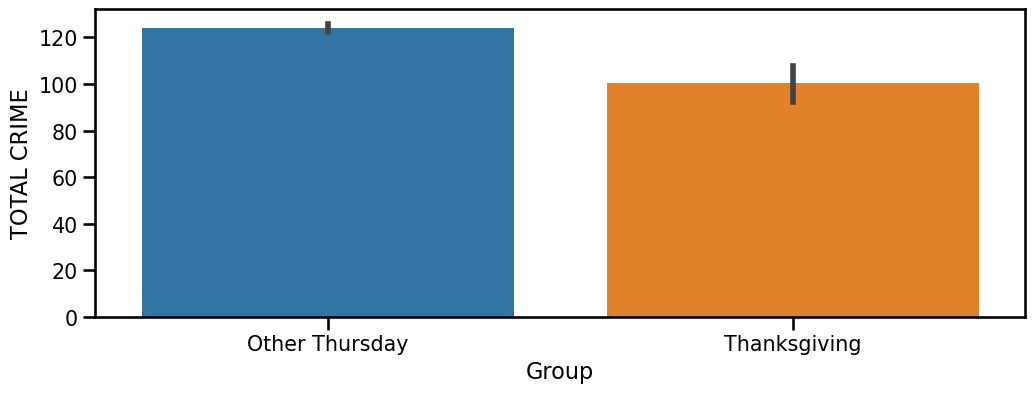

In [122]:
ax = sns.barplot(data=plot_df, x='Group', y='TOTAL CRIME');

We can see that Thanksgiving Days have fewer crimes than Other Thursdays. The next step would be to perform a hypothesis test to see if there is a significant difference or not.

# (Optional) Feature Engineering: Holidays


## Feature Engineering - Holidays
Checking for Holidays:
Reference: https://towardsdatascience.com/5-minute-guide-to-detecting-holidays-in-python-c270f8479387
We will install and use a new package called holidays.
holidays Documentation

In [123]:
!pip install holidays

In [124]:
import holidays
import datetime as dt
from holidays import country_holidays

In [125]:
## making a date range that covers full dataset
all_days = pd.date_range(df["Date"].min(), df["Date"].max())
all_days

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23',
               '2023-03-24', '2023-03-25'],
              dtype='datetime64[ns]', length=4467, freq='D')

## Getting General US Holidays


In [126]:
## Create an instance of the US country holidays.
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [127]:
## Testing first date
print(all_days[0])
us_holidays.get(all_days[0])

2011-01-01 00:00:00


"New Year's Day"

In [128]:
## Getting us holidays for all dates
holiday_list = [us_holidays.get(day) for day in all_days]
holiday_list[:5]

["New Year's Day", None, None, None, None]

## Getting Sub-Region Holidays

In [129]:
# For a specific subdivisions (e.g. state or province):
md_holidays = country_holidays('US', subdiv='MD')
md_holidays

holidays.country_holidays('US', subdiv='MD')

Now let's create a columns for US holidays and Maryland Holidays in our DataFrame:



In [130]:
## Saving both holiday types as columns
df["US Holiday"] = [us_holidays.get(day) for day in df['Date']]
df['MD Holiday'] = [md_holidays.get(day) for day in df['Date']]
df.head()

,CrimeCode,Description,Inside_Outside,Weapon,Gender,Age,Race,Ethnicity,District,Neighborhood,Latitude,Longitude,Total_Incidents,Date,Year,Month,MonthName,DayOfWeek,DayNum,Weekend,HourOfDay,US Holiday,US_Holiday,MD Holiday
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2A,RAPE,NaN,OTHER,M,16.0,BLACK_OR_AFRICAN_AMERICAN,NaN,WESTERN,HARLEM PARK,39.298868,-76.639339,1,2011-01-01,2011,1,January,Saturday,5,True,0,New Year's Day,True,New Year's Day
2011-01-01 00:00:00,6G,LARCENY,I,NaN,F,26.0,WHITE,NaN,SOUTHERN,FEDERAL HILL,39.277032,-76.613387,1,2011-01-01,2011,1,January,Saturday,5,True,0,New Year's Day,True,New Year's Day
2011-01-01 00:00:00,6E,LARCENY,O,NaN,M,44.0,BLACK_OR_AFRICAN_AMERICAN,NaN,WESTERN,MOSHER,39.295730,-76.661589,1,2011-01-01,2011,1,January,Saturday,5,True,0,New Year's Day,True,New Year's Day
2011-01-01 00:01:00,6J,LARCENY,I,NaN,M,24.0,WHITE,NaN,SOUTHERN,FEDERAL HILL,39.274917,-76.612816,1,2011-01-01,2011,1,January,Saturday,5,True,0,New Year's Day,True,New Year's Day
2011-01-01 00:01:00,6G,LARCENY,I,NaN,NaN,NaN,UNKNOWN,NaN,SOUTHEAST,GREEKTOWN,39.284330,-76.552329,1,2011-01-01,2011,1,January,Saturday,5,True,0,New Year's Day,True,New Year's Day


In [131]:
## US Holidays
df['US Holiday'].value_counts()

New Year's Day                                     1904
Labor Day                                          1678
Columbus Day                                       1676
Independence Day                                   1537
Memorial Day                                       1532
Veterans Day                                       1524
Martin Luther King Jr. Day                         1404
Washington's Birthday                              1296
Christmas Day                                      1247
Thanksgiving                                       1203
New Year's Day (Observed)                           484
Christmas Day (Observed)                            436
Veterans Day (Observed)                             394
Independence Day (Observed)                         389
Juneteenth National Independence Day                267
Juneteenth National Independence Day (Observed)     206
Name: US Holiday, dtype: int64

In [132]:
## MD Holidays
df['MD Holiday'].value_counts()

New Year's Day                                             1904
Labor Day                                                  1678
Columbus Day                                               1676
Independence Day                                           1537
Memorial Day                                               1532
Veterans Day                                               1524
American Indian Heritage Day                               1460
Washington's Birthday                                      1296
Martin Luther King Jr. Day                                 1293
Christmas Day                                              1247
Thanksgiving                                               1203
New Year's Day (Observed)                                   484
Christmas Day (Observed)                                    436
Inauguration Day                                            409
Veterans Day (Observed)                                     394
Independence Day (Observed)             

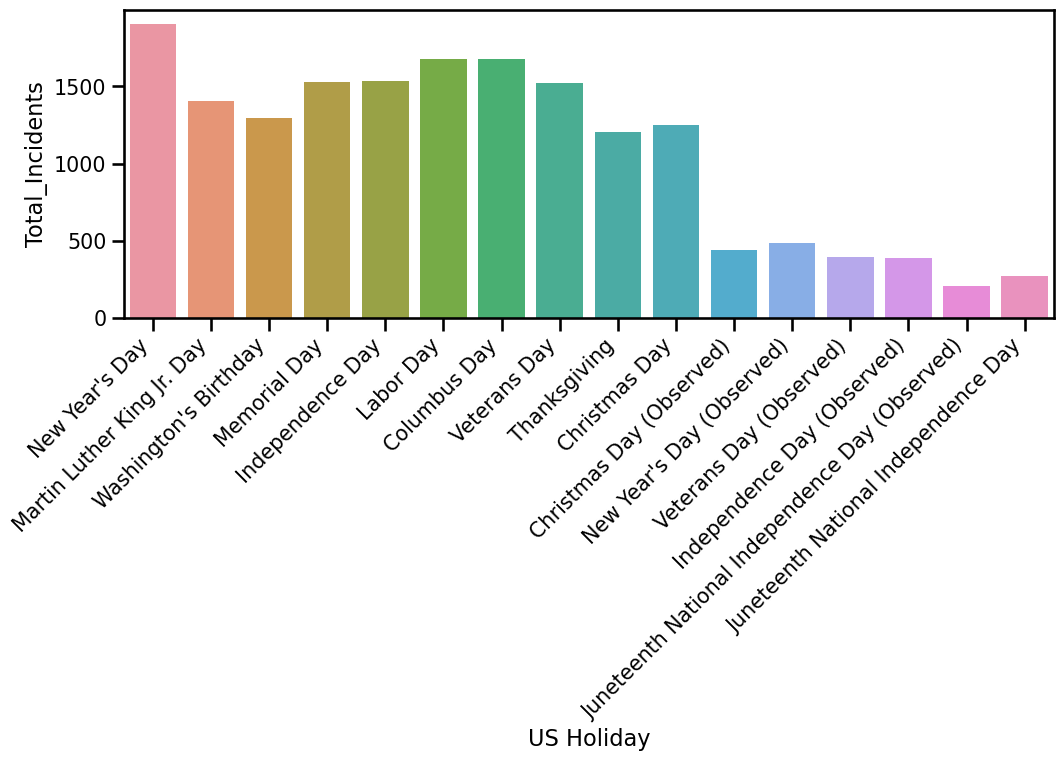

In [133]:
ax = sns.barplot(data=df, x='US Holiday',y='Total_Incidents',estimator=np.sum)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right');

In [134]:
## Saving a binary is holiday feature
df['Is_Holiday'] = df['US Holiday'].notna()
df['Is_Holiday'].value_counts()

False    541007
True      17177
Name: Is_Holiday, dtype: int64